In [1]:
from keras.models import Sequential
from keras.layers import Masking, SimpleRNN, Dense
import statistics as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import math
from keras.regularizers import l1, l2
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
import time
from collections import Counter
from scipy.signal import find_peaks
import collections
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
import matplotlib.colors as colors
from sklearn.manifold import Isomap
import keras_tuner
from keras_tuner.tuners import Hyperband
from tensorflow.keras.optimizers import Adam
from scipy.signal import savgol_filter

In [2]:
sim_FF_df = pd.read_csv('form_factors.csv')
sim_TD_x_df = pd.read_csv('gpr_total_density_x_200.csv')
sim_TD_y_df = pd.read_csv('gpr_total_density_y_200.csv')

sim_FF_df = sim_FF_df.transpose()
sim_TD_x_df = sim_TD_x_df.transpose()
sim_TD_y_df = sim_TD_y_df.transpose()

exp_FF = pd.read_json('experiment_formfactors.json')
exp_FF_list = []
special = False
for i in range(0,exp_FF.shape[1]):
    x_start = round(exp_FF.iloc[0,i][0],4)
    x_end = round(exp_FF.iloc[0,i][-1],4)
    front_zeros = int(round(x_start/0.001))
    
    if front_zeros == 0:
        special = True
        x_start = round(exp_FF.iloc[0,i][1],4)
        front_zeros = int(round(x_start/0.001))
     
    denoising = savgol_filter(exp_FF.iloc[1,i],35,1)
    
    if special:
        front_padding = np.concatenate((np.zeros(front_zeros-1), denoising))
        back_padding = np.concatenate((front_padding, np.zeros(1000 - len(front_padding))))
        exp_FF_list.append(back_padding)
        continue
        
    front_padding = np.concatenate((np.zeros(front_zeros), denoising))
    back_padding = np.concatenate((front_padding, np.zeros(1000 - len(front_padding))))
    exp_FF_list.append(back_padding)
        
exp_FF_df = pd.DataFrame(exp_FF_list)
exp_FF_df = exp_FF_df.transpose()

In [11]:
exp_FF_df

0    1    2    3    4    5    6    7    8    9   ...   26   27   28  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

      29   30   31   32   33   34   35  
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  
..   ...  ...  ...  ...  ...  ...  ...  
995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[1000 rows x 36 columns]

(490, 1000)
(490, 400)
(123, 1000)
(123, 400)
(36, 1000)


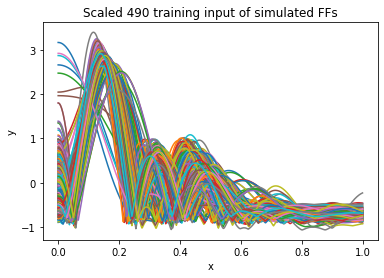

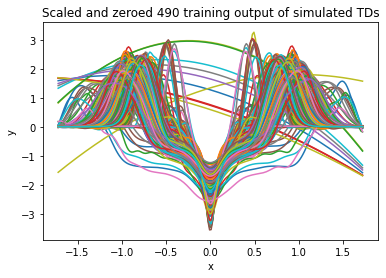

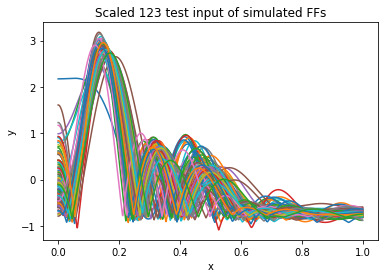

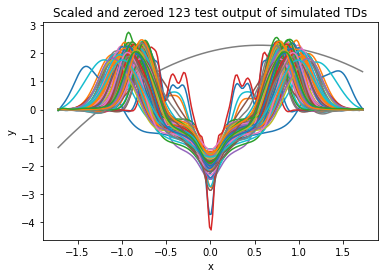

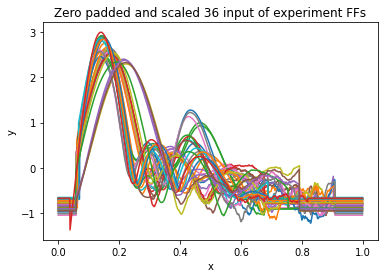

In [3]:
def data_plots(train_input, train_output, test_input, test_output, exp_input): 
    train_sim_FF_df = pd.DataFrame(train_input)
    for row in train_sim_FF_df.iloc:
        plt.plot(np.arange(0,1,0.001),row)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Scaled ' + str(train_sim_FF_df.shape[0]) + ' training input of simulated FFs')
    plt.show()
    
    train_sim_TD_df = pd.DataFrame(train_output)
    for row in train_sim_TD_df.iloc:
        plt.plot(row[:200],row[200:])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Scaled and zeroed ' + str(train_sim_TD_df.shape[0]) + ' training output of simulated TDs')
    plt.show()
    
    test_sim_FF_df = pd.DataFrame(test_input)
    for row in test_sim_FF_df.iloc:
        plt.plot(np.arange(0,1,0.001),row)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Scaled ' + str(test_sim_FF_df.shape[0]) + ' test input of simulated FFs')
    plt.show()
    
    test_sim_TD_df = pd.DataFrame(test_output)
    for row in test_sim_TD_df.iloc:
        plt.plot(row[:200],row[200:])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Scaled and zeroed ' + str(test_sim_TD_df.shape[0]) + ' test output of simulated TDs')
    plt.show()
    
    exp_FF_df = pd.DataFrame(exp_input)
    for row in exp_FF_df.iloc:
        plt.plot(np.arange(0,1,0.001),row)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Zero padded and scaled ' + str(exp_FF_df.shape[0]) + ' input of experiment FFs')
    plt.show()

def reduced_FF_to_TD_preprocessing(exp_FF_df, sim_FF_df, sim_TD_x_df, sim_TD_y_df):
    random.seed(42)
    train = random.sample(list(sim_FF_df.columns),int(round(613*0.8,0)))
    test = []
    for number in list(sim_FF_df.columns):
        if not number in train:
            test.append(number)
    
    exp_FF_scaled_values = []
    for column in exp_FF_df.columns:
        #scaling = (exp_FF_df[column] - exp_FF_df[column].mean()) / exp_FF_df[column].std()
        #exp_FF_scaled_values.append(savgol_filter(scaling,35,1))
        exp_FF_scaled_values.append((exp_FF_df[column] - exp_FF_df[column].mean()) / exp_FF_df[column].std())
    
    exp_FF_scaled_df = pd.DataFrame(exp_FF_scaled_values)
    exp_FF_scaled_df = exp_FF_scaled_df.transpose()
    exp_FF_scaled_df.columns = exp_FF_df.columns
             
    FF_scaled_values = []
    for column in sim_FF_df.columns:
        FF_scaled_values.append((sim_FF_df[column] - sim_FF_df[column].mean()) / sim_FF_df[column].std())
    
    sim_FF_scaled_df = pd.DataFrame(FF_scaled_values)
    sim_FF_scaled_df = sim_FF_scaled_df.transpose()
    sim_FF_scaled_df.columns = sim_FF_df.columns
            
    sim_TD_x_df = sim_TD_x_df
    TD_x_scaled_values = []
    for column in sim_TD_x_df.columns:
        TD_x_scaled_values.append((sim_TD_x_df[column] - sim_TD_x_df[column].mean()) / sim_TD_x_df[column].std())
        
    TD_x_scaled_df = pd.DataFrame(TD_x_scaled_values)
    TD_x_scaled_df = TD_x_scaled_df.transpose()
    TD_x_scaled_df.columns = sim_TD_x_df.columns
    
    TD_y_scaled_values = []
    for column in sim_TD_y_df.columns:
        TD_y_scaled_values.append((sim_TD_y_df[column] - sim_TD_y_df[column].mean()) / sim_TD_y_df[column].std())
    
    TD_y_scaled_df = pd.DataFrame(TD_y_scaled_values)
    TD_y_scaled_df = TD_y_scaled_df.transpose()
    TD_y_scaled_df.columns = sim_TD_y_df.columns
    
    zeroing = round((TD_y_scaled_df.iloc[0]+TD_y_scaled_df.iloc[-1])/2,3)
    TD_y_scaled_df = TD_y_scaled_df.subtract(zeroing)
             
    sim_TD_df = pd.concat([TD_x_scaled_df, TD_y_scaled_df], axis=0)
    train_input = sim_FF_scaled_df[train].transpose().astype(np.float32)
    train_output = sim_TD_df[train].transpose().values.astype(np.float32)
    test_input = sim_FF_scaled_df[test].transpose().astype(np.float32)
    test_output = sim_TD_df[test].transpose().values.astype(np.float32)
    exp_input = exp_FF_scaled_df.transpose().values.astype(np.float32)
            
    print(train_input.shape)
    print(train_output.shape)
    print(test_input.shape)
    print(test_output.shape)
    print(exp_input.shape)
     
    return train_input, train_output, test_input, test_output, exp_input 

train_input, train_output, test_input, test_output, exp_input = reduced_FF_to_TD_preprocessing(exp_FF_df, sim_FF_df, sim_TD_x_df, sim_TD_y_df)
data_plots(train_input, train_output, test_input, test_output, exp_input)

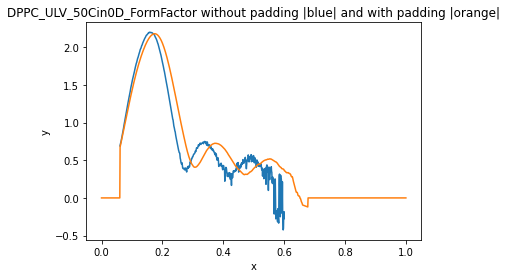

0



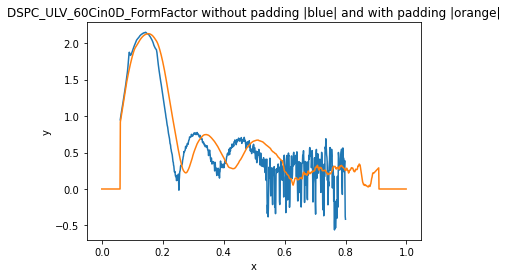

1



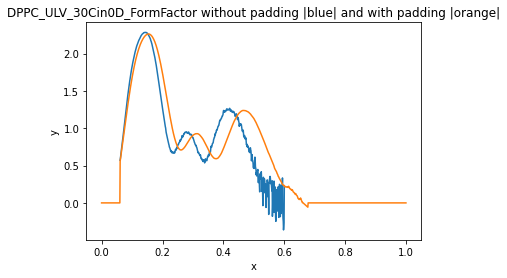

2



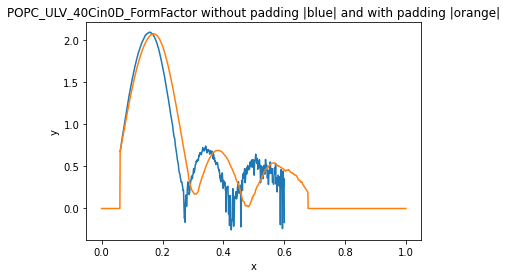

3



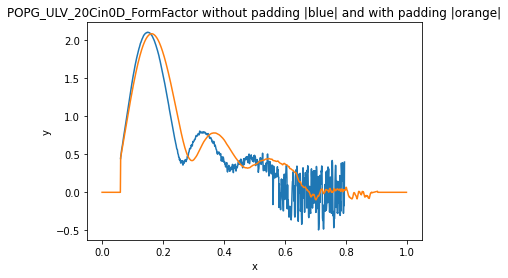

4



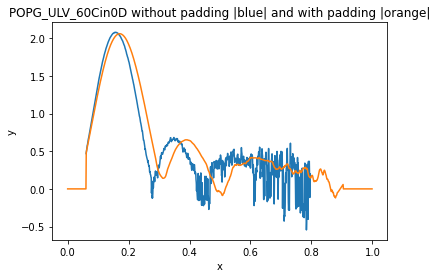

5



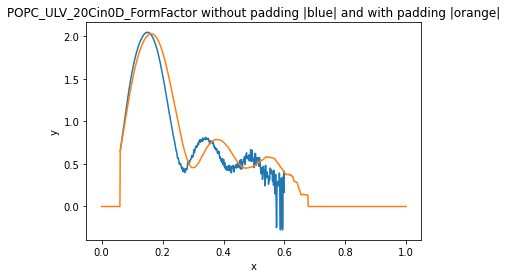

6



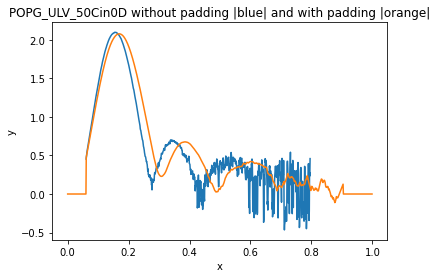

7



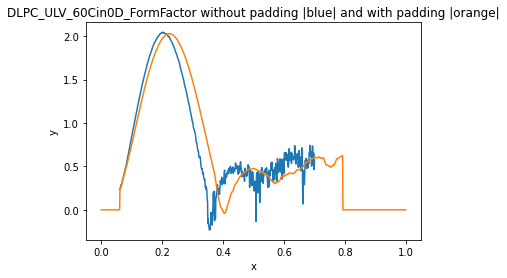

8



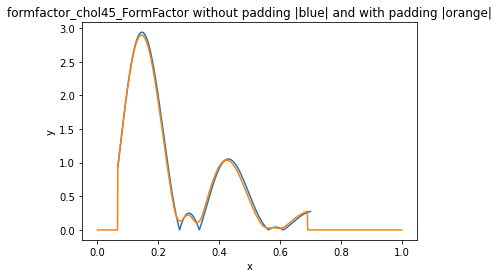

9



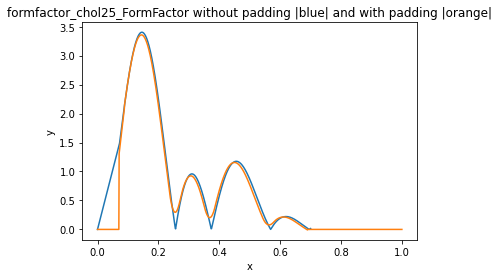

10



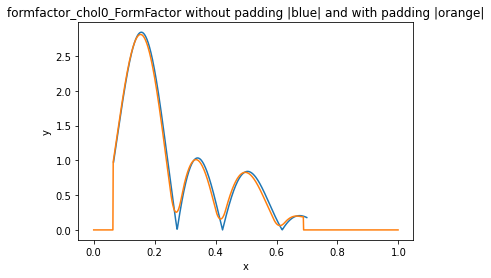

11



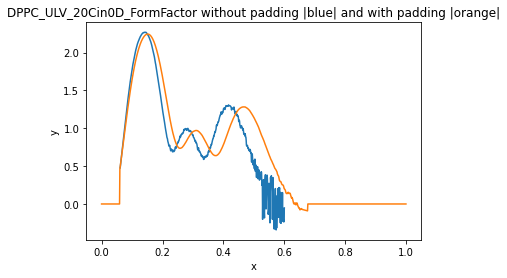

12



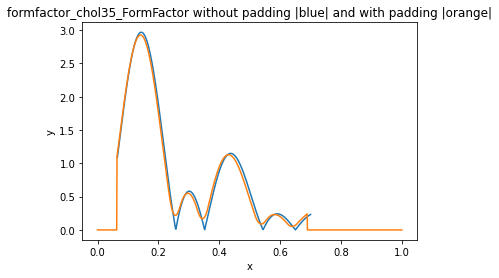

13



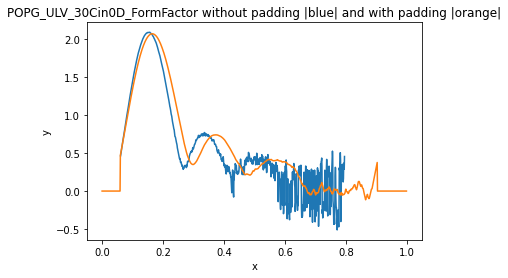

14



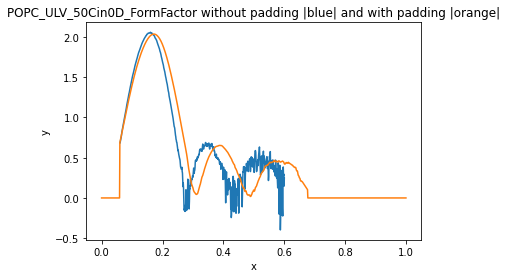

15



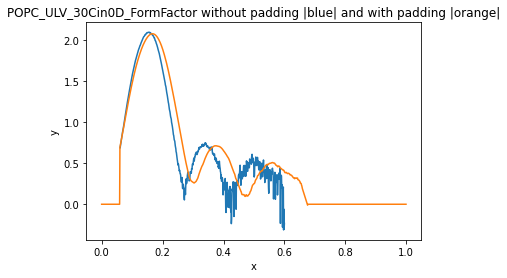

16



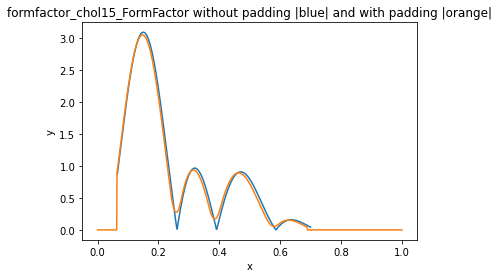

17



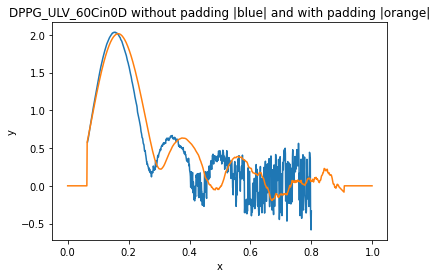

18



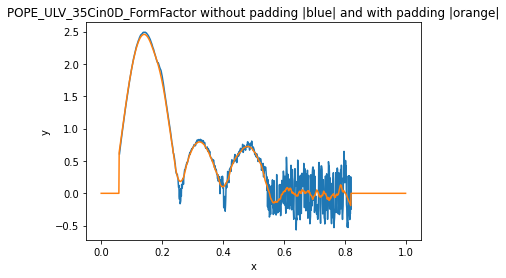

19



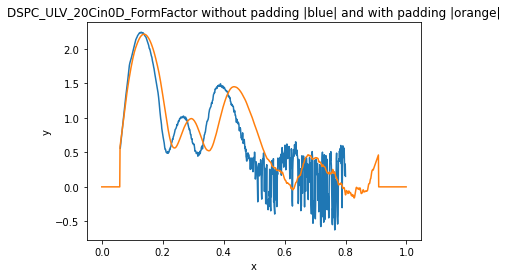

20



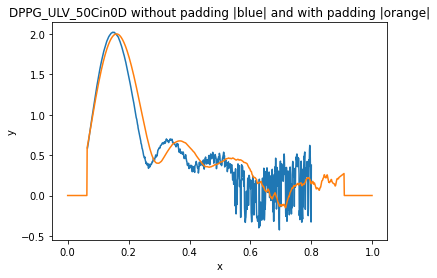

21



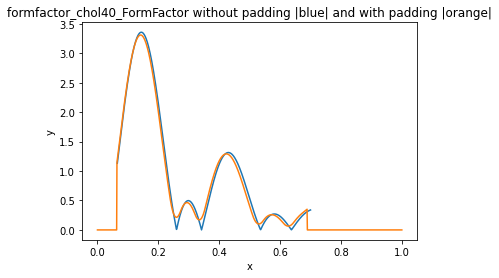

22



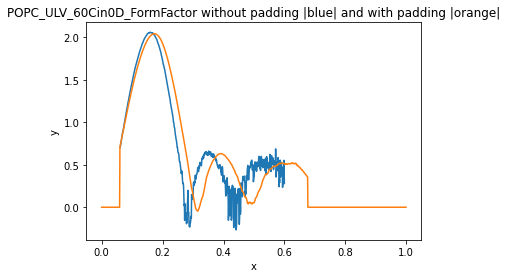

23



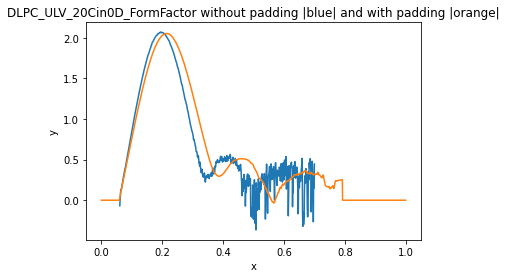

24



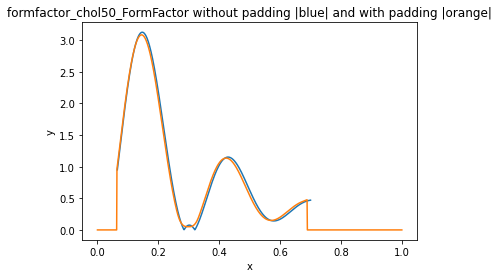

25



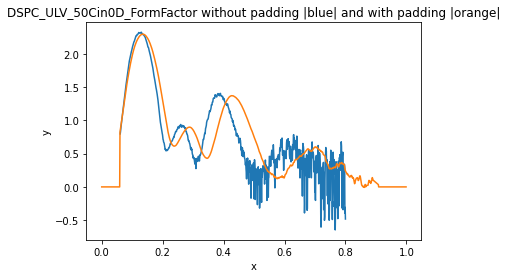

26



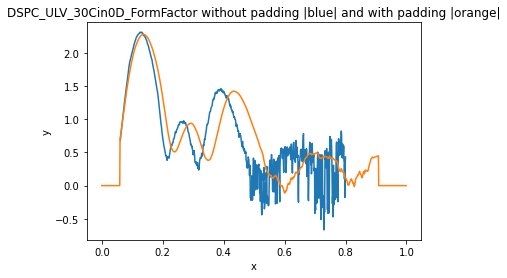

27



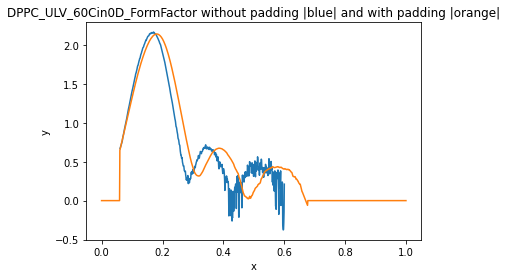

28



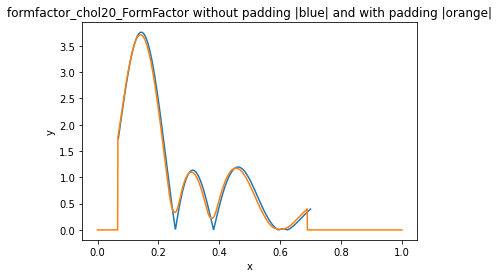

29



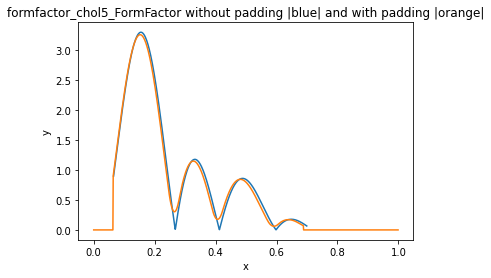

30



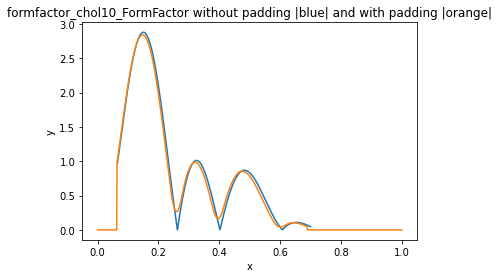

31



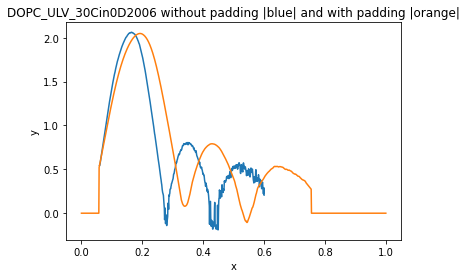

32



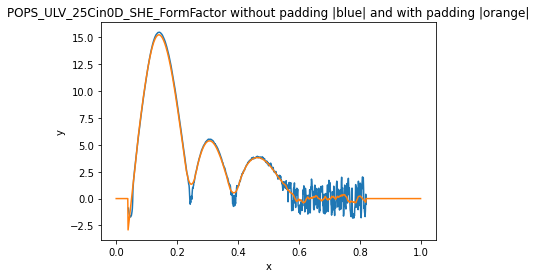

33



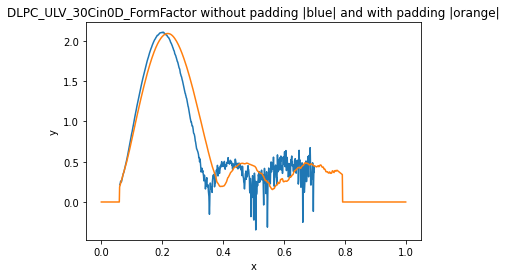

34



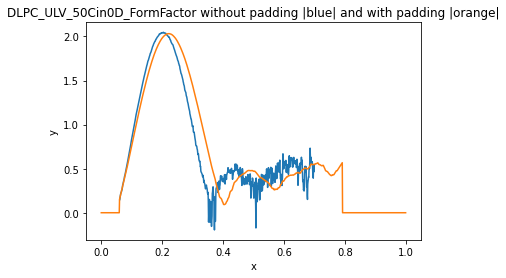

35



In [4]:
index = 0
for column in exp_FF.columns:
    plt.plot(exp_FF.iloc[0,index],exp_FF.iloc[1,index])
    plt.plot(np.arange(0,1,0.001),exp_FF_df[index])
    plt.title(column + ' without padding |blue| and with padding |orange|')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    print(index)
    print('')
    index = index + 1

In [5]:
def single_average_loss(actual,prediction):
    length = int(actual.shape[0]/2)
    
    t_x = actual[0:length]
    t_y = actual[length:]
    p_x = prediction[0:length]
    p_y = prediction[length:]
    
    distance_sum = 0
    for i in range(0,length):
        distance_sum = distance_sum + math.sqrt((t_x[i]-p_x[i])**2 + (t_y[i]-p_y[i])**2)

    return (distance_sum/length)

def metrics(actual,prediction):
    amount = int(actual.shape[0])
    length = int(actual.shape[1]/2)
    
    index = 0
    loss_list = []
    for data in prediction:
        p_x = data[0:length]
        p_y = data[length:]
        t_x = actual[index][0:length]
        t_y = actual[index][length:]
         
        distance_sum = 0
        for i in range(0,length):
            distance_sum = distance_sum + math.sqrt((t_x[i]-p_x[i])**2 + (t_y[i]-p_y[i])**2)
            
        loss_list.append(distance_sum/length)
        index = index + 1
     
    average_loss = sum(loss_list)/amount
    mode_loss = Counter(np.round(loss_list,5)).most_common(10)
    median_loss = st.median(np.round(loss_list,5))
    
    sorted_loss = np.sort(loss_list)
    loss_quantile_50 = np.percentile(sorted_loss,50)
    loss_quantile_80 = np.percentile(sorted_loss,80)
    loss_quantile_95 = np.percentile(sorted_loss,95)
    
    plt.hist(np.round(loss_list,5), bins = amount)
    plt.xlabel('Loss')
    plt.ylabel('Amount')
    plt.title('Loss frequency for test data of ' + str(amount))
    plt.show()
    
    return [average_loss, mode_loss, median_loss, loss_quantile_50, loss_quantile_80, loss_quantile_95]

def simulation_plots(actual,prediction):
    random.seed(42)
    train = random.sample(range(0,len(actual)),10)
    for number in train:
        length = int(len(prediction[0])/2)
        x_1 = prediction[number][0:length]
        y_1 = prediction[number][length:]
        plt.plot(x_1,y_1,c='b')

        x_2 = actual[number][0:length]
        y_2 = actual[number][length:]
        plt.plot(x_2,y_2,c='r')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Output curve of the ten random predictions |blue| against actual |red|')
    plt.show() 
    
    index = 0
    for points in prediction:
        p_x = points[0:length]
        p_y = points[length:]
        plt.scatter(p_x,p_y,c='b', label='Prediction', alpha=0.25)
        t_x = actual[index][0:length].tolist()
        t_y = actual[index][length:].tolist()
        plt.scatter(t_x,t_y,c='r', label = 'Actual', alpha=0.50)
        index = index + 1

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Output scatterplot of prediction |blue| and actual |red| data')
    plt.show()
    
    length = int(len(prediction[0])/2)
    x_1 = prediction[train[0]][0:length]
    y_1 = prediction[train[0]][length:]
    plt.plot(x_1,y_1,c='b')

    x_2 = actual[train[0]][0:length]
    y_2 = actual[train[0]][length:]
    
    plt.plot(x_2,y_2,c='r')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Curve of index ' + str(train[0]) + ' with predictions |blue| against actual |red|')
    plt.show() 
    print('The loss of the curve ' + str(single_average_loss(actual[train[0]],prediction[train[0]])))
    
    length = int(len(prediction[0])/2)
    x_1 = prediction[train[4]][0:length]
    y_1 = prediction[train[4]][length:]
    plt.plot(x_1,y_1,c='b')

    x_2 = actual[train[4]][0:length]
    y_2 = actual[train[4]][length:]
    
    plt.plot(x_2,y_2,c='r')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Curve of index ' + str(train[4]) + ' with predictions |blue| against actual |red|')
    plt.show() 
    print('The loss of the curve ' + str(single_average_loss(actual[train[4]],prediction[train[4]])))
    
    length = int(len(prediction[0])/2)
    x_1 = prediction[train[9]][0:length]
    y_1 = prediction[train[9]][length:]
    plt.plot(x_1,y_1,c='b')

    x_2 = actual[train[9]][0:length]
    y_2 = actual[train[9]][length:]
    
    plt.plot(x_2,y_2,c='r')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Curve of index ' + str(train[9]) + ' with predictions |blue| against actual |red|')
    plt.show() 
    print('The loss of the curve ' + str(single_average_loss(actual[train[9]],prediction[train[9]])))
    
def experiment_predictions(exp_input,prediction):
    random.seed(42)
    train = random.sample(range(0,len(prediction)),10)
    length = int(len(prediction[0])/2)
    for number in train:
        plt.subplot(1,2,1)
        plt.plot(np.arange(0,1,0.001), exp_input[number])
        plt.subplot(1,2,2)
        plt.plot(prediction[number][0:length],prediction[number][length:])
        plt.suptitle('TD prediction for experiment FF index ' + str(number))
        plt.show()
        
    index = 0
    for points in prediction:
        p_x = points[0:length]
        p_y = points[length:]
        plt.scatter(p_x,p_y,c='b')
        index = index + 1

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Output scatterplot of prediction on experiment data')
    plt.show()

Used time: 164.33774995803833 seconds


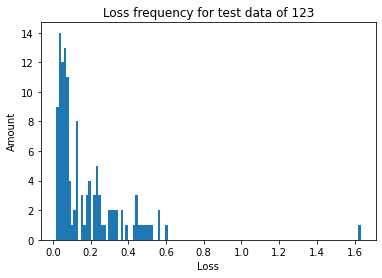

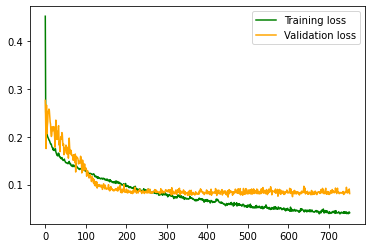

Loss average is: 0.17522611229282162
Loss mode is: [(0.03336, 2), (0.19438, 1), (0.59574, 1), (0.15521, 1), (0.18948, 1), (0.46872, 1), (0.07709, 1), (0.22381, 1), (1.63167, 1), (0.2353, 1)]
Loss median is: 0.08663


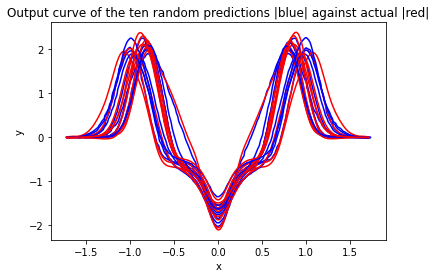

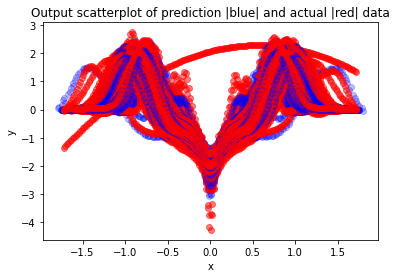

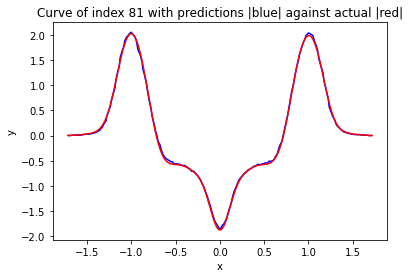

The loss of the curve 0.03062204612134611


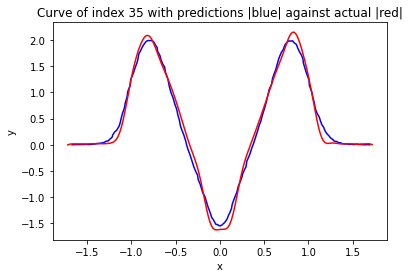

The loss of the curve 0.12551482690598104


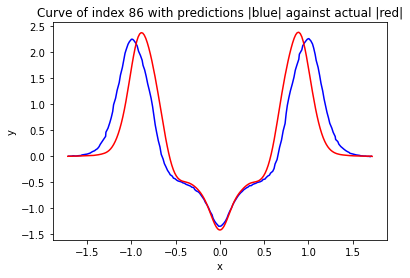

The loss of the curve 0.3320733531959854


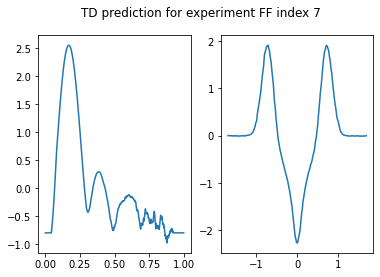

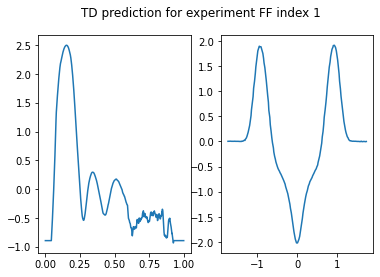

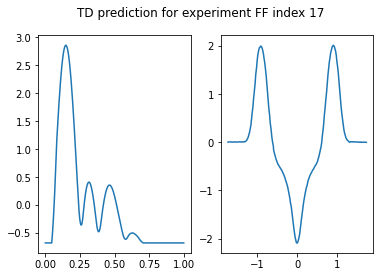

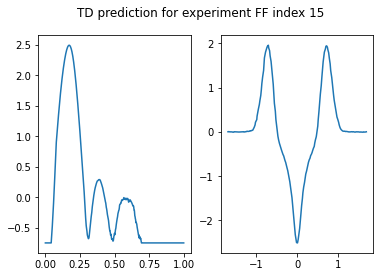

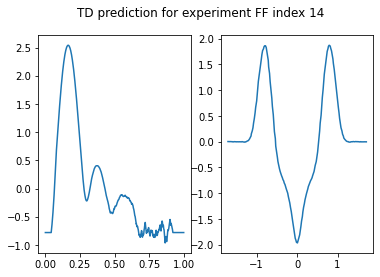

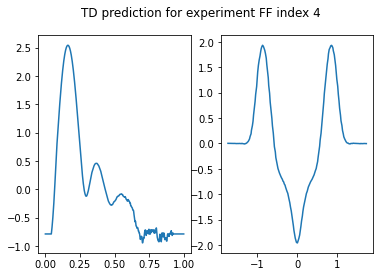

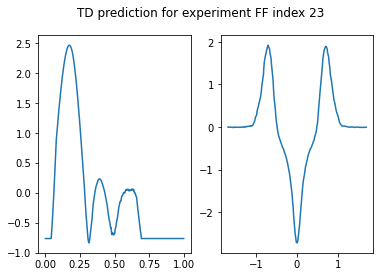

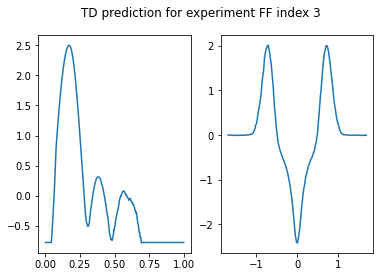

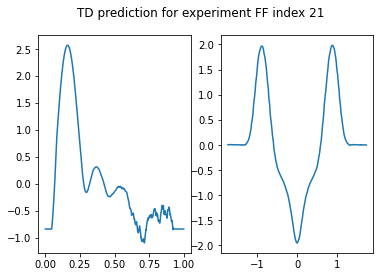

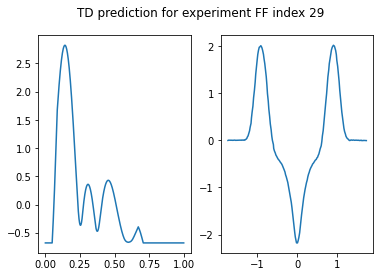

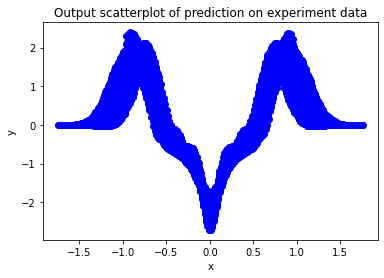

In [16]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=300, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(1500, activation='relu')(inputs)
x = layers.Dropout(0.1, seed = 42)(x)
x = layers.Dense(500, activation='relu')(x)
x = layers.Dropout(0.15, seed = 42)(x)
x = layers.Dense(500, activation='relu')(x)
x = layers.Dropout(0.05, seed = 42)(x)
x = layers.Dense(2500, activation='relu')(x)
x = layers.Dropout(0.05, seed = 42)(x)
x = layers.Dense(1500, activation='relu')(x)
x = layers.Dropout(0.1, seed = 42)(x)
outputs = layers.Dense(400, activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adamax(), loss='mean_absolute_error')

history = model.fit(train_input, train_output, batch_size=50, epochs=2000, validation_split=0.2, callbacks=callbacks, verbose=0)

general_end_time = time.time()

print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')

results = metrics(test_output, model.predict(test_input))

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
simulation_plots(test_output,model.predict(test_input))
experiment_predictions(exp_input,model.predict(exp_input))

Used time: 250.8451931476593 seconds


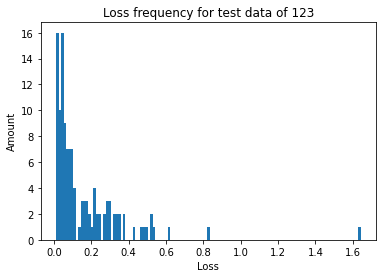

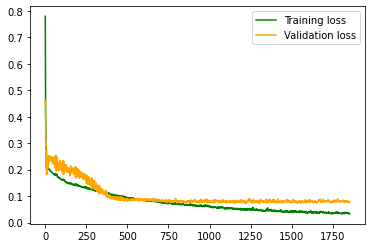

Loss average is: 0.16060880204550534
Loss mode is: [(0.02205, 2), (0.14895, 1), (0.61404, 1), (0.08419, 1), (0.16751, 1), (0.49176, 1), (0.03586, 1), (0.07578, 1), (1.64201, 1), (0.09947, 1)]
Loss median is: 0.08132


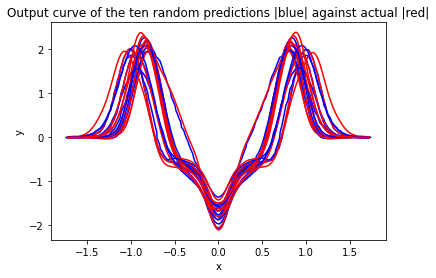

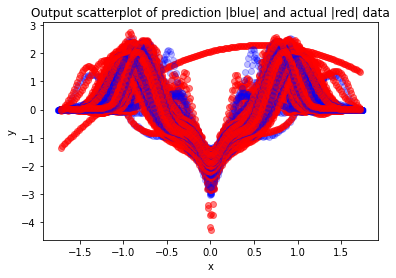

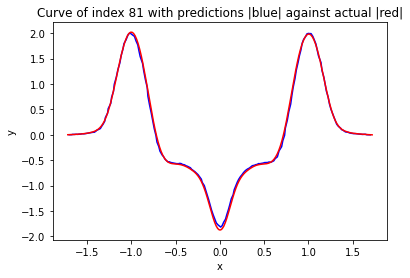

The loss of the curve 0.05729070428384206


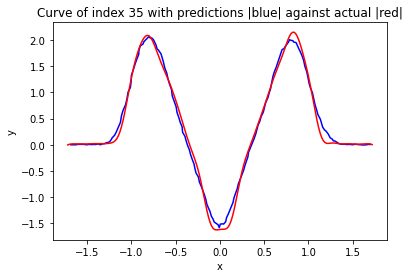

The loss of the curve 0.10131399481008085


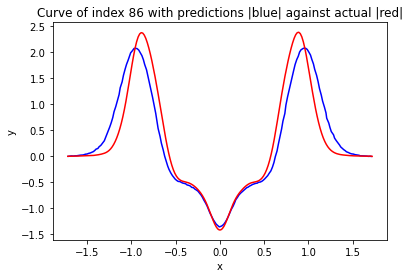

The loss of the curve 0.2643688445133818


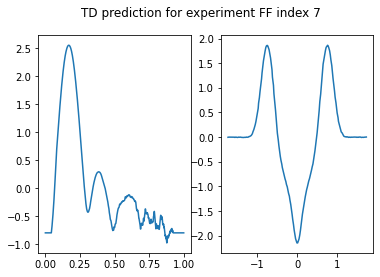

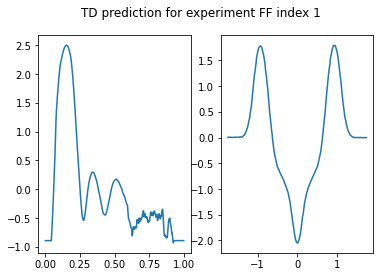

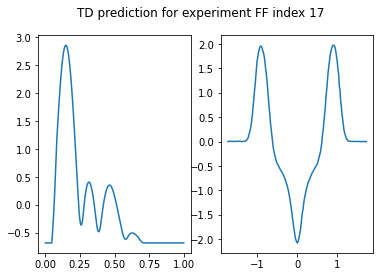

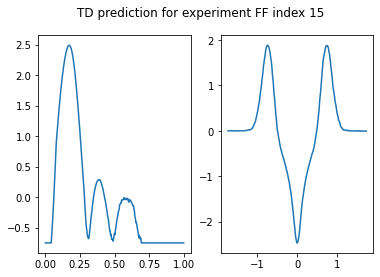

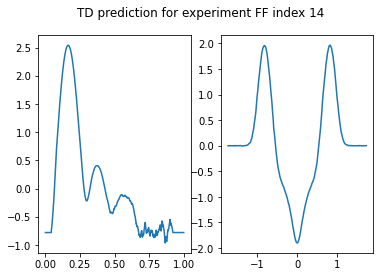

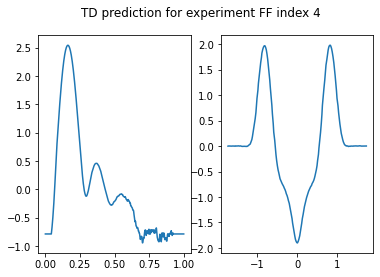

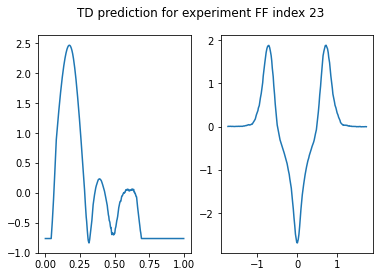

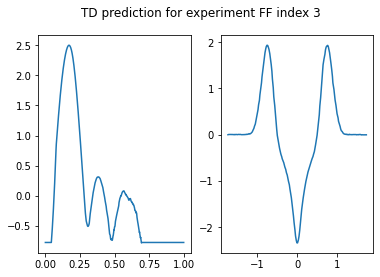

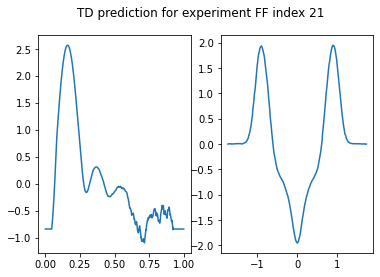

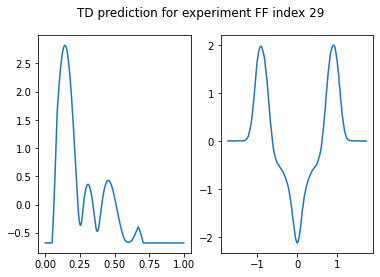

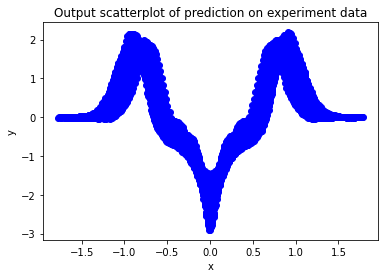

In [17]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=300, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(1500, activation='relu')(inputs)
x = layers.Dropout(0.1, seed = 42)(x)
x = layers.Dense(500, activation='relu')(x)
x = layers.Dropout(0.15, seed = 42)(x)
x = layers.Dense(500, activation='relu')(x)
x = layers.Dropout(0.05, seed = 42)(x)
x = layers.Dense(2500, activation='relu')(x)
x = layers.Dropout(0.05, seed = 42)(x)
x = layers.Dense(1500, activation='relu')(x)
x = layers.Dropout(0.1, seed = 42)(x)
outputs = layers.Dense(400, activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adamax(), loss='mean_absolute_error')

history = model.fit(train_input, train_output, batch_size=300, epochs=2000, validation_split=0.2, callbacks=callbacks, verbose=0)

general_end_time = time.time()

print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')

results = metrics(test_output, model.predict(test_input))

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
simulation_plots(test_output,model.predict(test_input))
experiment_predictions(exp_input,model.predict(exp_input))

Used time: 163.52095317840576 seconds


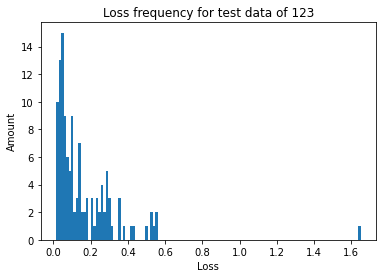

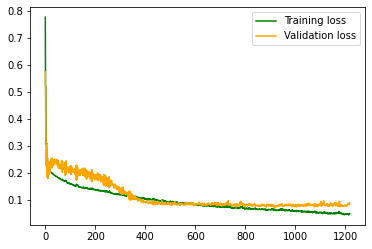

Loss average is: 0.16150180334573838
Loss mode is: [(0.01647, 2), (0.14458, 1), (0.53309, 1), (0.16627, 1), (0.20327, 1), (0.37391, 1), (0.14992, 1), (1.64988, 1), (0.24946, 1), (0.07982, 1)]
Loss median is: 0.09645
Loss 50th quantile: 0.09644636421500113
Loss 80th quantile: 0.26449380342111095
Loss 95th quantile: 0.4943859755140188


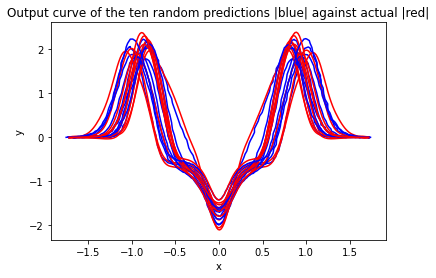

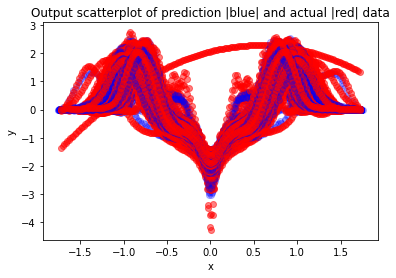

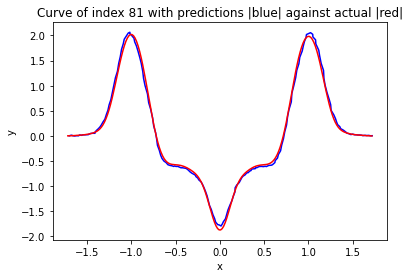

The loss of the curve 0.05335994194043865


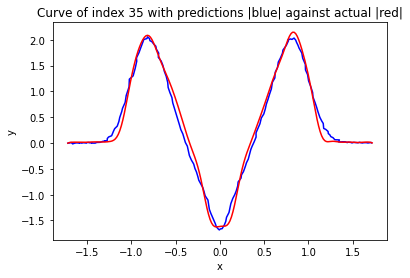

The loss of the curve 0.09752386061629323


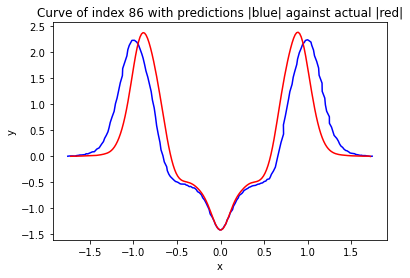

The loss of the curve 0.2963585546901205


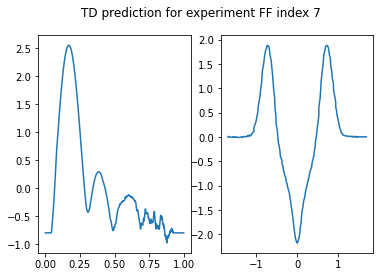

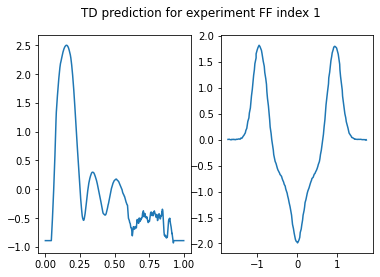

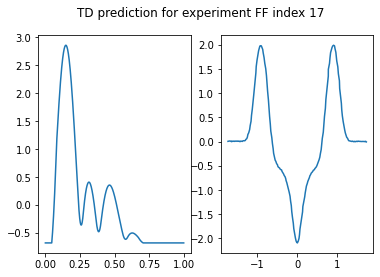

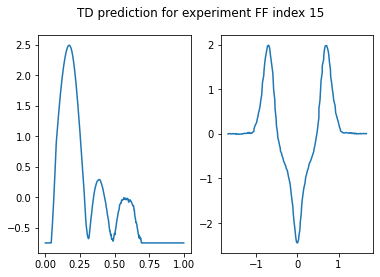

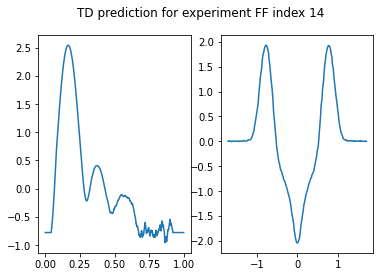

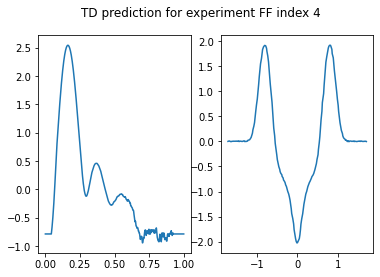

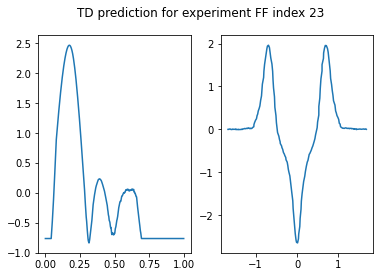

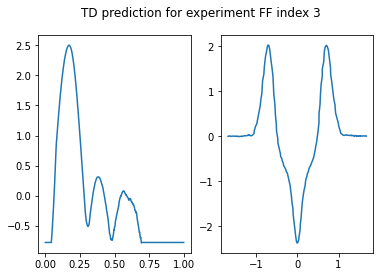

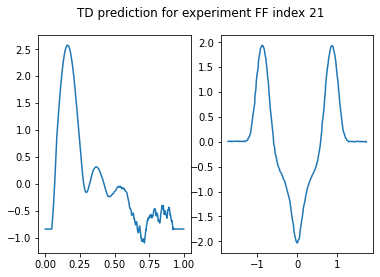

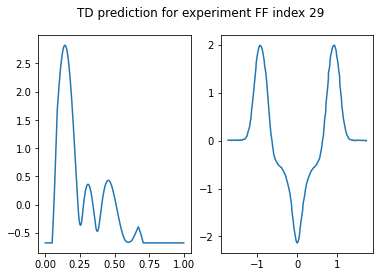

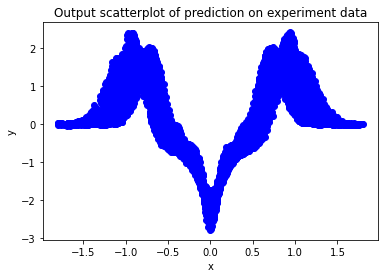

In [21]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=300, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(1500, activation='relu')(inputs)
x = layers.Dropout(0.1, seed = 42)(x)
x = layers.Dense(500, activation='relu')(x)
x = layers.Dropout(0.15, seed = 42)(x)
x = layers.Dense(500, activation='relu')(x)
x = layers.Dropout(0.05, seed = 42)(x)
x = layers.Dense(2500, activation='relu')(x)
x = layers.Dropout(0.05, seed = 42)(x)
x = layers.Dense(1500, activation='relu')(x)
x = layers.Dropout(0.1, seed = 42)(x)
outputs = layers.Dense(400, activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adamax(), loss='mean_absolute_error')

history = model.fit(train_input, train_output, batch_size=300, epochs=2000, validation_split=0.2, callbacks=callbacks, verbose=0)

general_end_time = time.time()

print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')

results = metrics(test_output, model.predict(test_input))

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Loss 50th quantile: ' + str(results[3]))
print('Loss 80th quantile: ' + str(results[4]))
print('Loss 95th quantile: ' + str(results[5]))
simulation_plots(test_output,model.predict(test_input))
experiment_predictions(exp_input,model.predict(exp_input))

Used time: 236.14326095581055 seconds


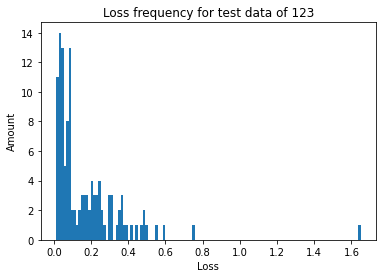

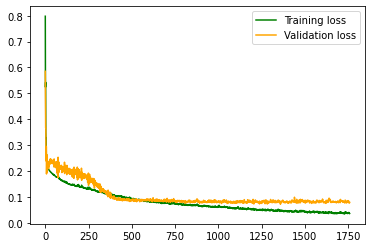

Loss average is: 0.1705635382754099
Loss mode is: [(0.18464, 1), (0.59373, 1), (0.0813, 1), (0.19953, 1), (0.47696, 1), (0.01347, 1), (0.3605, 1), (1.64903, 1), (0.07558, 1), (0.08207, 1)]
Loss median is: 0.08775
Loss 50th quantile: 0.08775297538517687
Loss 80th quantile: 0.2657269215436858
Loss 95th quantile: 0.48299605126575706


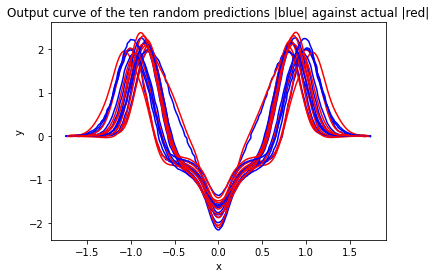

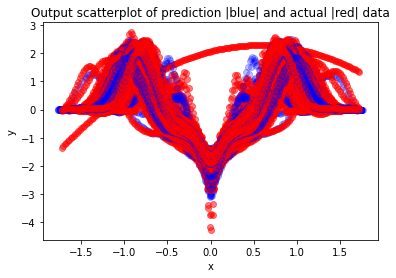

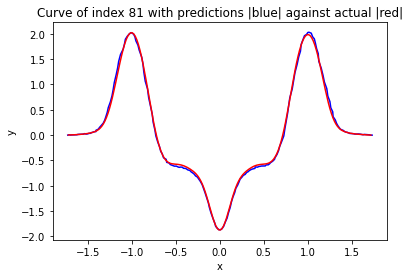

The loss of the curve 0.018844556950072623


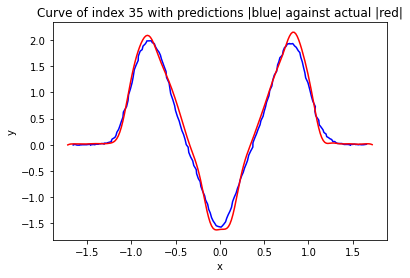

The loss of the curve 0.11967865272975226


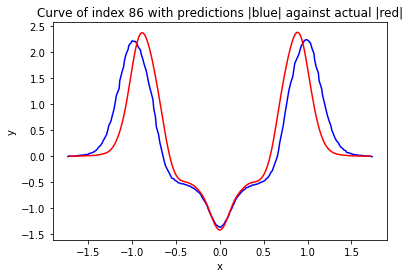

The loss of the curve 0.2986687802610943


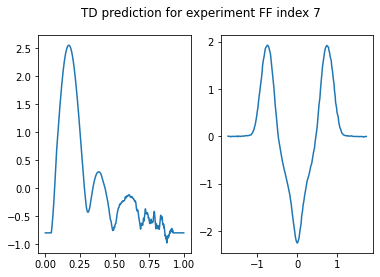

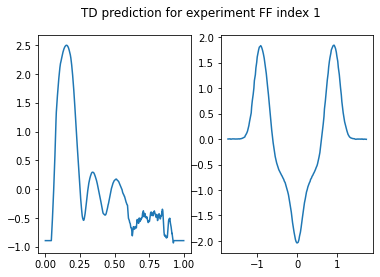

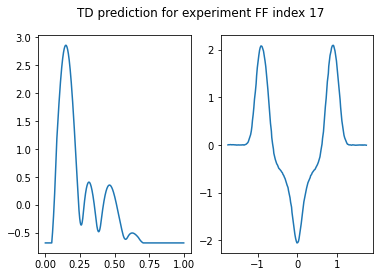

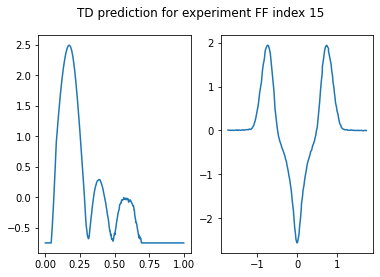

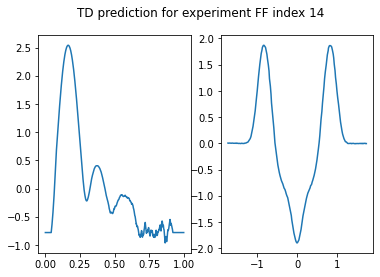

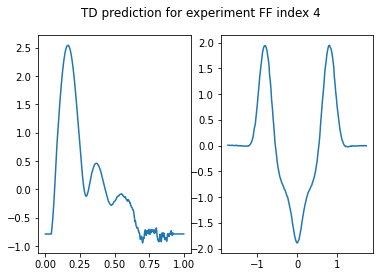

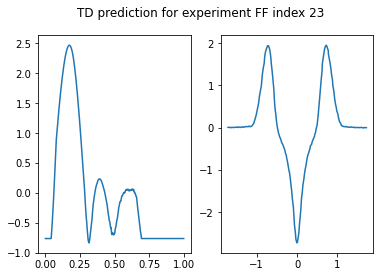

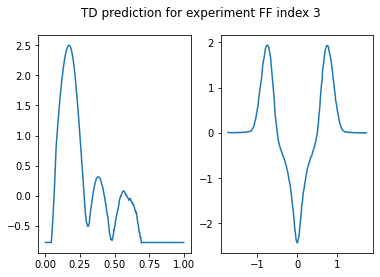

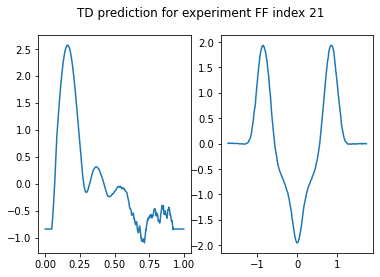

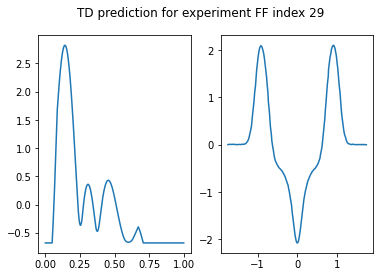

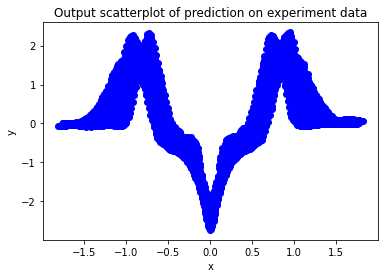

In [22]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=400, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(1500, activation='relu')(inputs)
x = layers.Dropout(0.1, seed = 42)(x)
x = layers.Dense(500, activation='relu')(x)
x = layers.Dropout(0.15, seed = 42)(x)
x = layers.Dense(500, activation='relu')(x)
x = layers.Dropout(0.05, seed = 42)(x)
x = layers.Dense(2500, activation='relu')(x)
x = layers.Dropout(0.05, seed = 42)(x)
x = layers.Dense(1500, activation='relu')(x)
x = layers.Dropout(0.1, seed = 42)(x)
outputs = layers.Dense(400, activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adamax(), loss='mean_absolute_error')

history = model.fit(train_input, train_output, batch_size=300, epochs=3000, validation_split=0.2, callbacks=callbacks, verbose=0)

general_end_time = time.time()

print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')

results = metrics(test_output, model.predict(test_input))

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Loss 50th quantile: ' + str(results[3]))
print('Loss 80th quantile: ' + str(results[4]))
print('Loss 95th quantile: ' + str(results[5]))
simulation_plots(test_output,model.predict(test_input))
experiment_predictions(exp_input,model.predict(exp_input))

Trial 254 Complete [00h 01m 01s]
loss: 0.10343392938375473

Best loss So Far: 0.0926387682557106
Total elapsed time: 00h 28m 14s
INFO:tensorflow:Oracle triggered exit
{'num_layers': 4, 'dense_0_units': 1000, 'dropout_0': 0.05, 'dense_1_units': 3000, 'dropout_1': 0.05, 'dense_2_units': 500, 'dropout_2': 0.05, 'dense_3_units': 3000, 'dropout_3': 0.1, 'dense_4_units': 1000, 'dropout_4': 0.2, 'tuner/epochs': 100, 'tuner/initial_epoch': 34, 'tuner/bracket': 3, 'tuner/round': 3, 'tuner/trial_id': '0206'}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              1001000   
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3000)              3003000   
______________

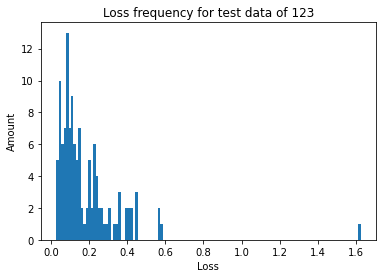

Loss average is: 0.1820859071571981
Loss mode is: [(0.0587, 2), (0.23161, 1), (0.56775, 1), (0.35719, 1), (0.07988, 1), (0.44384, 1), (0.03398, 1), (0.05001, 1), (1.62598, 1), (0.19708, 1)]
Loss median is: 0.12254


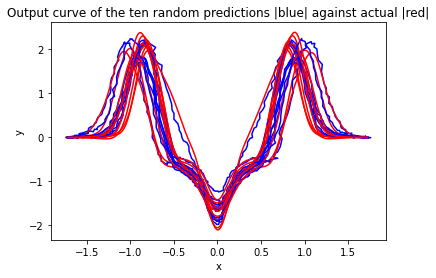

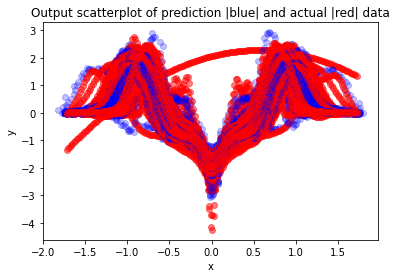

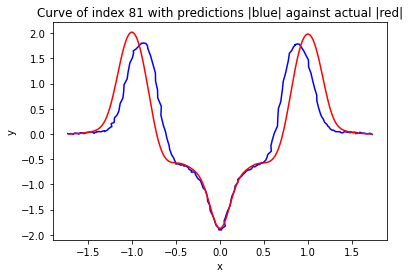

The loss of the curve 0.3067199175622919


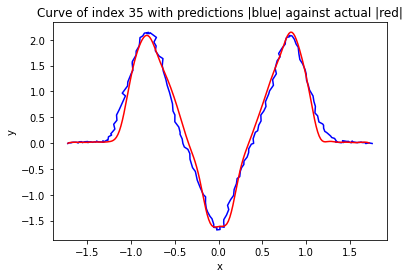

The loss of the curve 0.10583222065205575


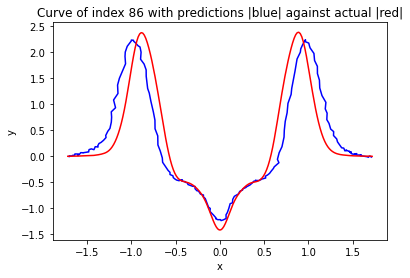

The loss of the curve 0.2935458771491274


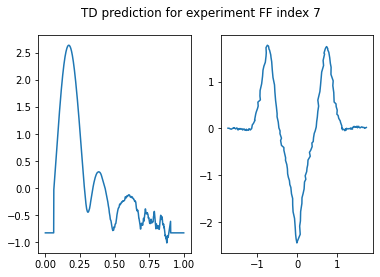

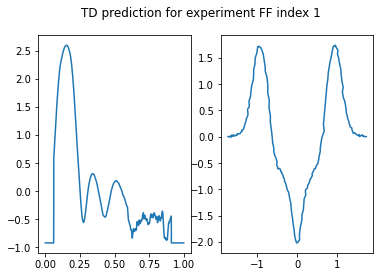

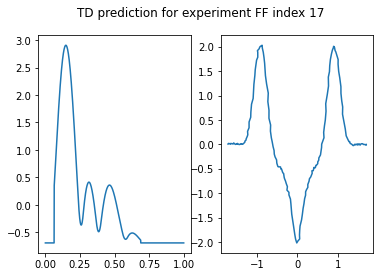

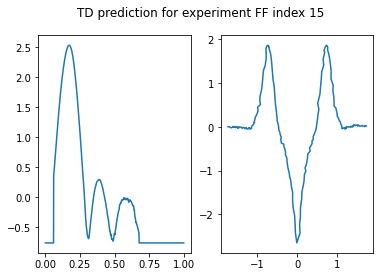

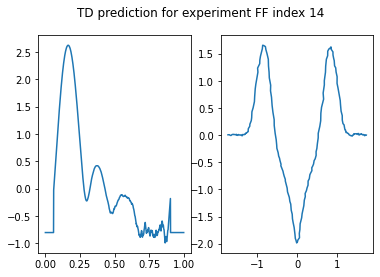

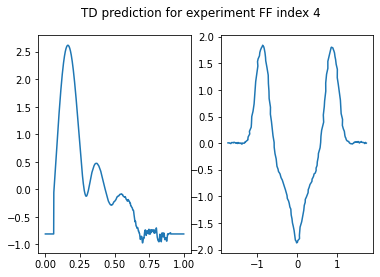

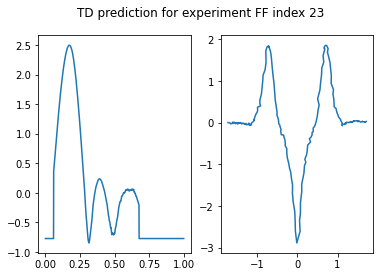

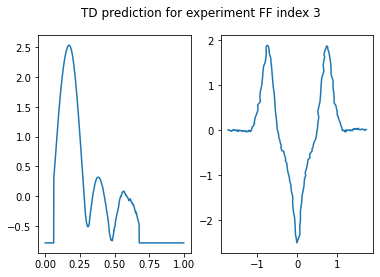

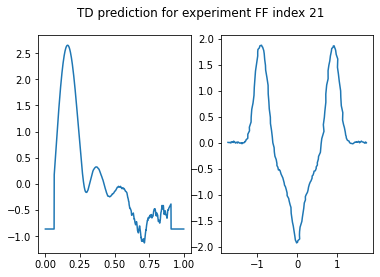

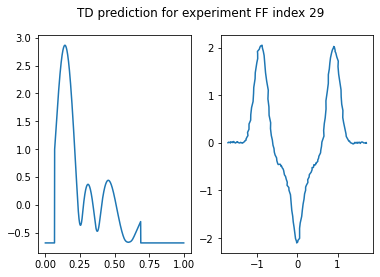

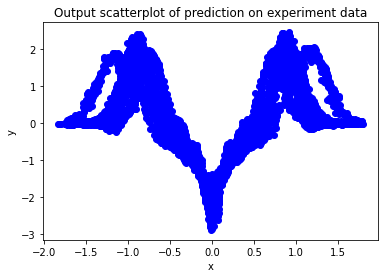

In [9]:
from tensorflow.keras import backend as K

def gelu(x):
    cdf = 0.5 * (1.0 + tf.tanh(
        (np.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3)))))
    return x * cdf

def build_model(hp):
    model = keras.Sequential()
    
    model.add(layers.Input(shape=(1000,)))
    
    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(layers.Dense(units=hp.Int(f'dense_{i}_units', min_value=500, max_value=3000, step=500), 
                               activation=gelu))
        model.add(layers.Dropout(hp.Float(f'dropout_{i}', min_value=0.05, max_value=0.30, step=0.05), seed=42))
    
    model.add(layers.Dense(units=400, activation = 'linear'))
    
    model.compile(optimizer=tf.keras.optimizers.Adamax(),loss='mean_absolute_error')
    
    return model

tuner = Hyperband(
    build_model,
    objective='loss',
    max_epochs=100,
    factor=3,
    directory='my_dir',
    project_name='FF_to_TD_13')

tuner.search(train_input, train_output,
             epochs=100,
             validation_data=(test_input, test_output))

best_model = tuner.get_best_models(num_models=1)[0]

best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)

two_best_models = tuner.get_best_models(num_models=1)
print(two_best_models[0].summary())

results = metrics(test_output, best_model.predict(test_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
simulation_plots(test_output,best_model.predict(test_input))
experiment_predictions(exp_input,best_model.predict(exp_input))

Used time: 209.3809323310852 seconds


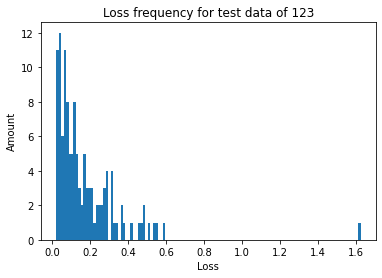

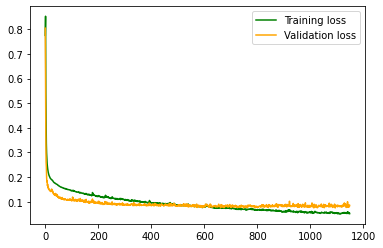

Loss average is: 0.1712485664711286
Loss mode is: [(0.03952, 2), (0.1716, 1), (0.59065, 1), (0.1334, 1), (0.17367, 1), (0.48333, 1), (0.10641, 1), (0.06521, 1), (1.62424, 1), (0.28972, 1)]
Loss median is: 0.11659
Loss 50th quantile: 0.11659430844769325
Loss 80th quantile: 0.27285279889260544
Loss 95th quantile: 0.47798586283698813


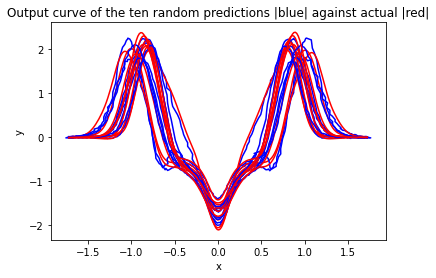

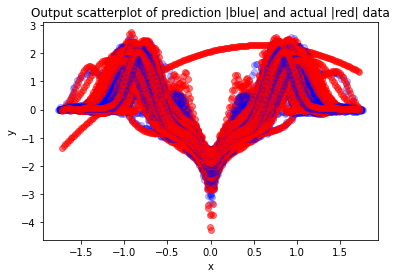

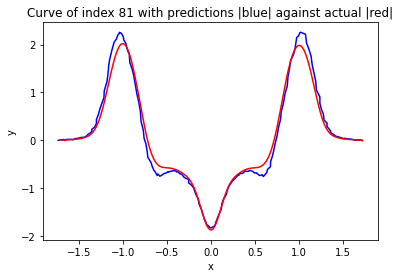

The loss of the curve 0.10029993869413202


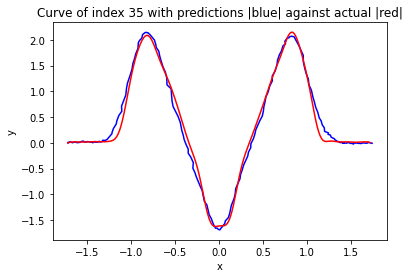

The loss of the curve 0.08739965416191917


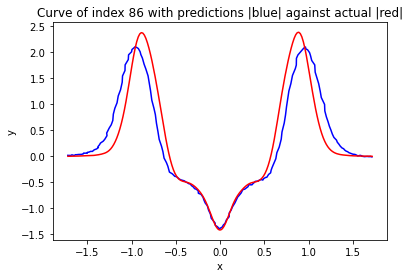

The loss of the curve 0.25701675892984477


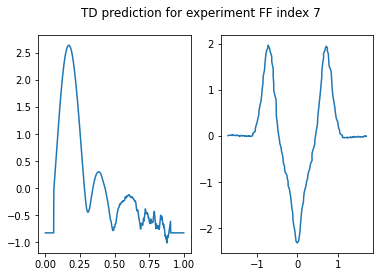

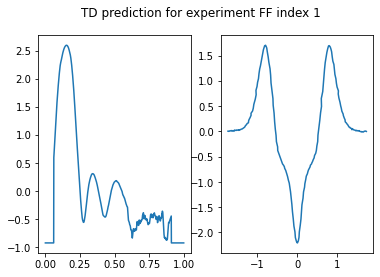

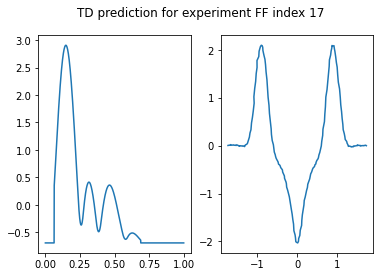

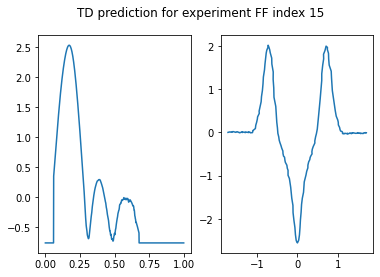

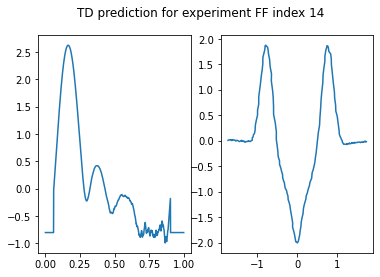

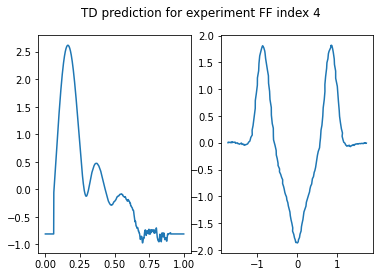

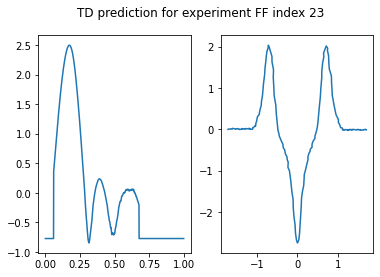

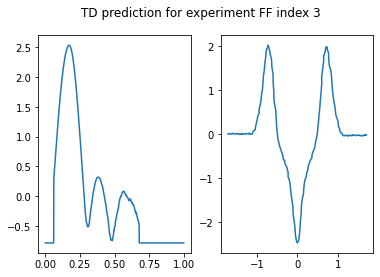

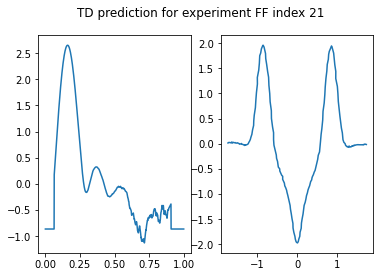

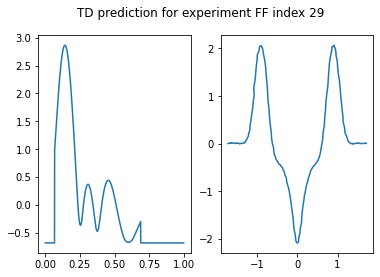

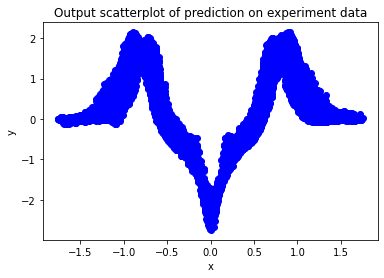

In [10]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=400, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(1000, activation=gelu)(inputs)
x = layers.Dropout(0.05, seed = 42)(x)
x = layers.Dense(3000, activation=gelu)(x)
x = layers.Dropout(0.05, seed = 42)(x)
x = layers.Dense(500, activation=gelu)(x)
x = layers.Dropout(0.05, seed = 42)(x)
x = layers.Dense(3000, activation=gelu)(x)
x = layers.Dropout(0.1, seed = 42)(x)
x = layers.Dense(1000, activation=gelu)(x)
x = layers.Dropout(0.2, seed = 42)(x)
outputs = layers.Dense(400, activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adamax(), loss='mean_absolute_error')

history = model.fit(train_input, train_output, batch_size=300, epochs=3000, validation_split=0.2, callbacks=callbacks, verbose=0)

general_end_time = time.time()

print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')

results = metrics(test_output, model.predict(test_input))

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Loss 50th quantile: ' + str(results[3]))
print('Loss 80th quantile: ' + str(results[4]))
print('Loss 95th quantile: ' + str(results[5]))
simulation_plots(test_output,model.predict(test_input))
experiment_predictions(exp_input,model.predict(exp_input))

Used time: 339.90732884407043 seconds


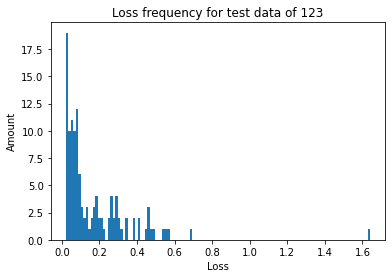

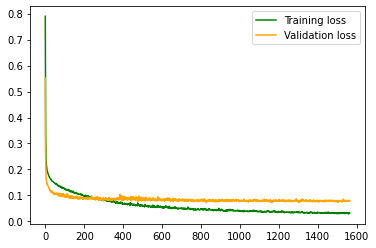

Loss average is: 0.16966899184132486
Loss mode is: [(0.18434, 1), (0.33836, 1), (0.08457, 1), (0.4637, 1), (0.49092, 1), (0.03229, 1), (0.41382, 1), (1.6412, 1), (0.13355, 1), (0.0764, 1)]
Loss median is: 0.08724
Loss 50th quantile: 0.08724411760867838
Loss 80th quantile: 0.27831259970003236
Loss 95th quantile: 0.47934406965907067


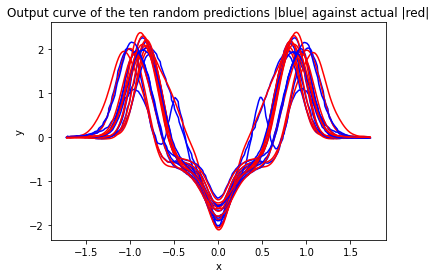

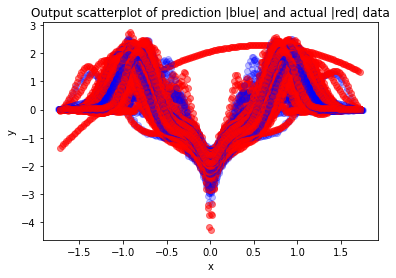

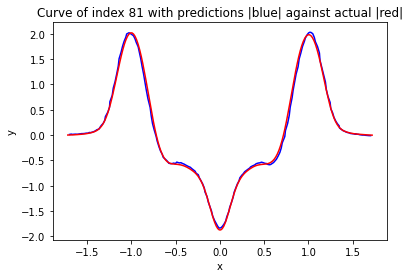

The loss of the curve 0.07090620423383075


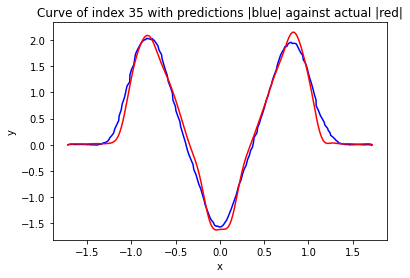

The loss of the curve 0.0970120324210043


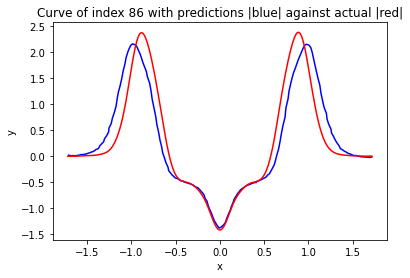

The loss of the curve 0.2791402554568209


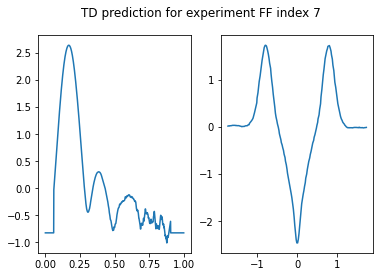

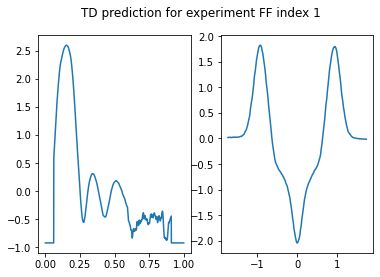

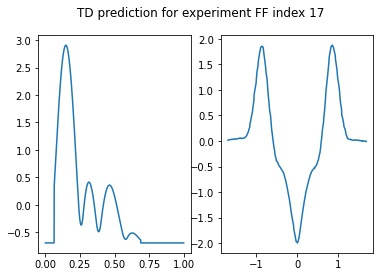

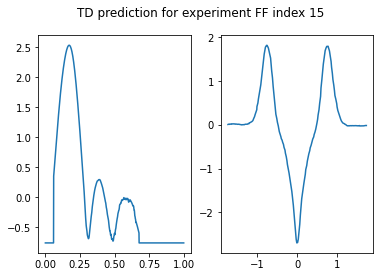

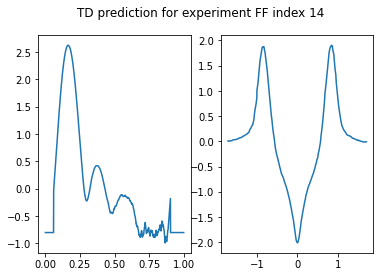

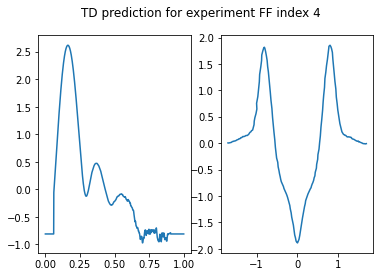

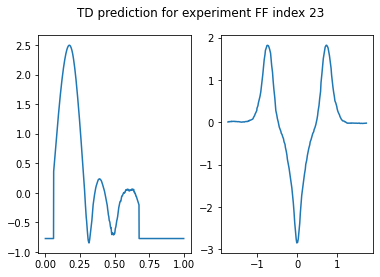

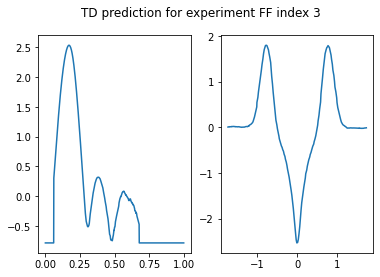

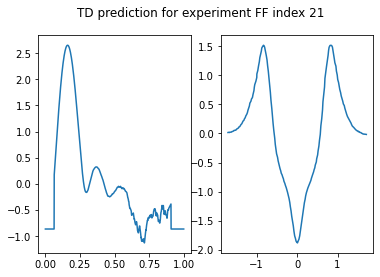

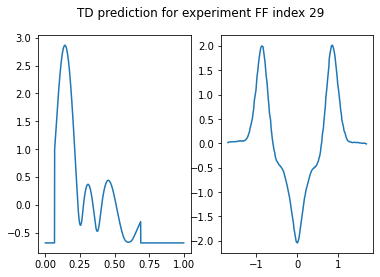

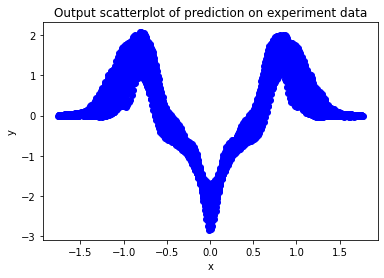

In [11]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=400, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(1000, activation=gelu)(inputs)
x = layers.Dropout(0.05, seed = 42)(x)
x = layers.Dense(3000, activation=gelu)(x)
x = layers.Dropout(0.05, seed = 42)(x)
x = layers.Dense(500, activation=gelu)(x)
x = layers.Dropout(0.05, seed = 42)(x)
x = layers.Dense(3000, activation=gelu)(x)
x = layers.Dropout(0.1, seed = 42)(x)
x = layers.Dense(1000, activation=gelu)(x)
x = layers.Dropout(0.2, seed = 42)(x)
outputs = layers.Dense(400, activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adamax(), loss='mean_absolute_error')

history = model.fit(train_input, train_output, batch_size=100, epochs=3000, validation_split=0.2, callbacks=callbacks, verbose=0)

general_end_time = time.time()

print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')

results = metrics(test_output, model.predict(test_input))

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Loss 50th quantile: ' + str(results[3]))
print('Loss 80th quantile: ' + str(results[4]))
print('Loss 95th quantile: ' + str(results[5]))
simulation_plots(test_output,model.predict(test_input))
experiment_predictions(exp_input,model.predict(exp_input))

Trial 254 Complete [00h 01m 03s]
loss: 0.11811160296201706

Best loss So Far: 0.10111084580421448
Total elapsed time: 00h 21m 56s
INFO:tensorflow:Oracle triggered exit
{'num_layers': 1, 'dense_0_units': 2500, 'dropout_0': 0.05, 'dense_1_units': 2000, 'dropout_1': 0.15000000000000002, 'dense_2_units': 500, 'dropout_2': 0.1, 'dense_3_units': 2000, 'dropout_3': 0.05, 'dense_4_units': 2000, 'dropout_4': 0.2, 'tuner/epochs': 100, 'tuner/initial_epoch': 34, 'tuner/bracket': 3, 'tuner/round': 3, 'tuner/trial_id': '0203'}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2500)              2502500   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 2500)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2500)              0        

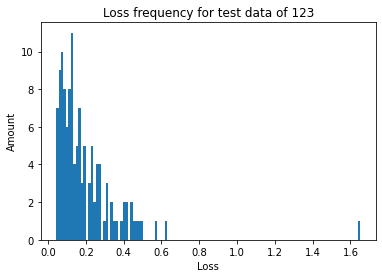

Loss average is: 0.1951328625591563
Loss mode is: [(0.24868, 1), (0.57281, 1), (0.36441, 1), (0.14402, 1), (0.34045, 1), (0.04247, 1), (0.15759, 1), (1.65242, 1), (0.24675, 1), (0.0988, 1)]
Loss median is: 0.14331


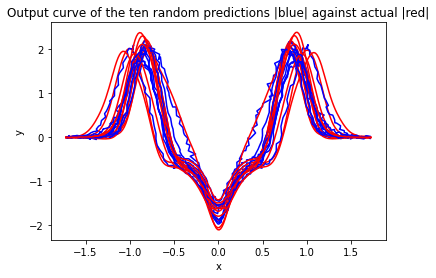

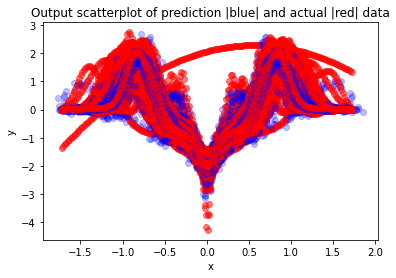

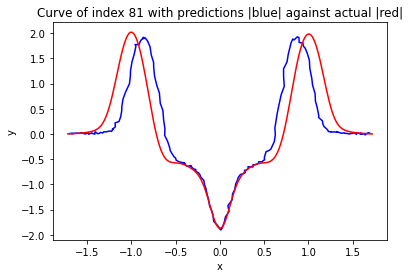

The loss of the curve 0.3075285541481055


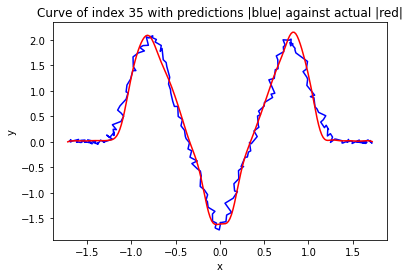

The loss of the curve 0.11679750066823213


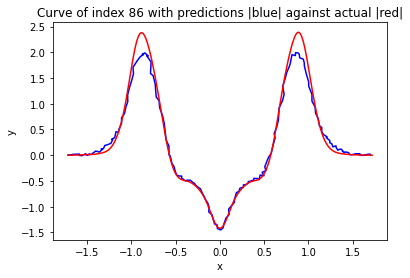

The loss of the curve 0.09073704509323227


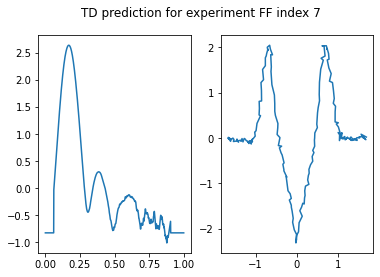

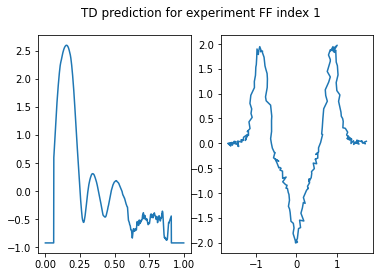

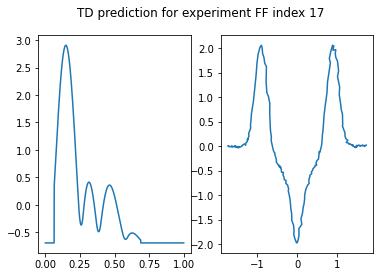

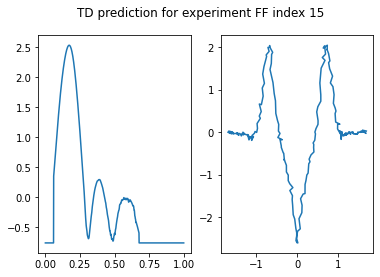

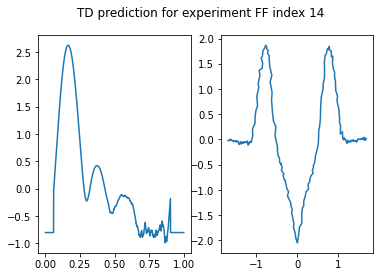

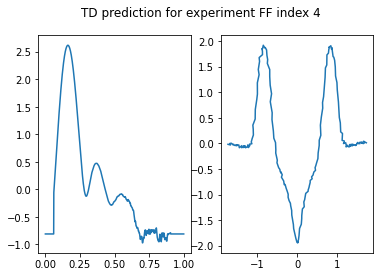

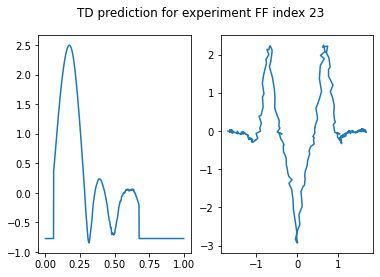

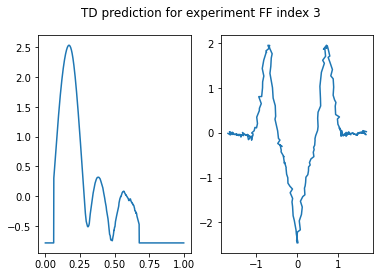

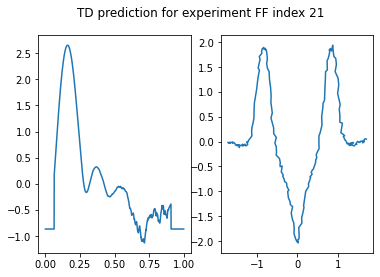

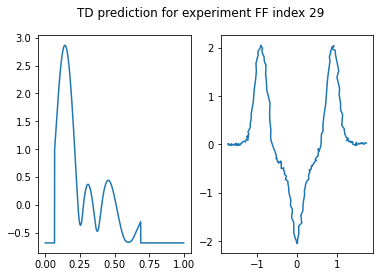

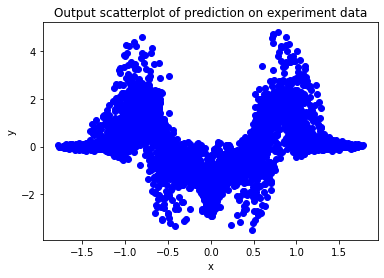

In [14]:
from keras.layers import LeakyReLU

def build_model(hp):
    model = keras.Sequential()
    
    model.add(layers.Input(shape=(1000,)))
    
    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(layers.Dense(units=hp.Int(f'dense_{i}_units', min_value=500, max_value=3000, step=500)))
        model.add(LeakyReLU(alpha=hp.Float(f'dropout_{i}', min_value=0.05, max_value=0.30, step=0.05)))
        model.add(layers.Dropout(hp.Float(f'dropout_{i}', min_value=0.05, max_value=0.30, step=0.05), seed=42))
    
    model.add(layers.Dense(units=400, activation = 'linear'))
    
    model.compile(optimizer=tf.keras.optimizers.Adamax(),loss='mean_absolute_error')
    
    return model

tuner = Hyperband(
    build_model,
    objective='loss',
    max_epochs=100,
    factor=3,
    directory='my_dir',
    project_name='FF_to_TD_14')

tuner.search(train_input, train_output,
             epochs=100,
             validation_data=(test_input, test_output))

best_model = tuner.get_best_models(num_models=1)[0]

best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)

two_best_models = tuner.get_best_models(num_models=1)
print(two_best_models[0].summary())

results = metrics(test_output, best_model.predict(test_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
simulation_plots(test_output,best_model.predict(test_input))
experiment_predictions(exp_input,best_model.predict(exp_input))

Used time: 189.86217093467712 seconds


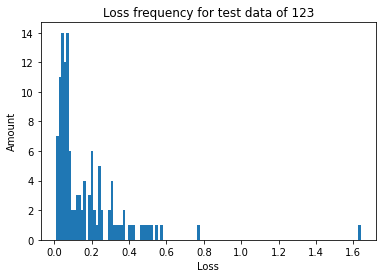

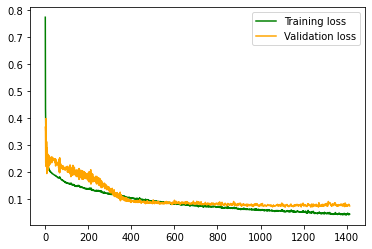

Loss average is: 0.16751614004828536
Loss mode is: [(0.19375, 1), (0.5425, 1), (0.08326, 1), (0.15623, 1), (0.48268, 1), (0.08738, 1), (0.07521, 1), (1.63835, 1), (0.19547, 1), (0.06231, 1)]
Loss median is: 0.08326


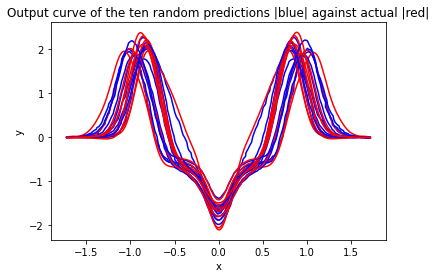

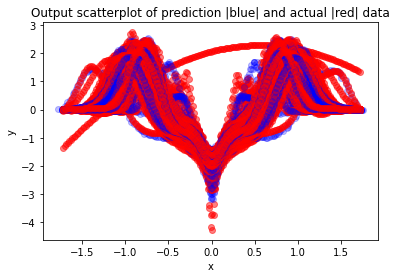

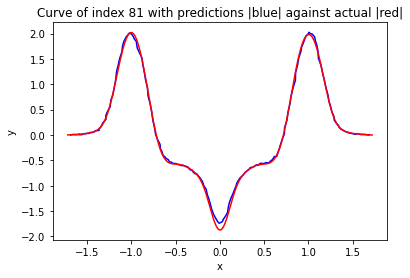

The loss of the curve 0.07333858108218931


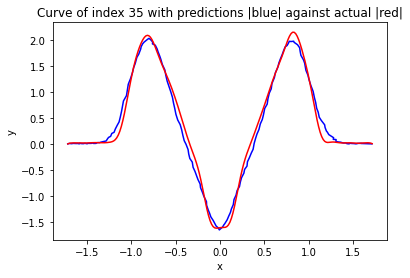

The loss of the curve 0.10106823942616153


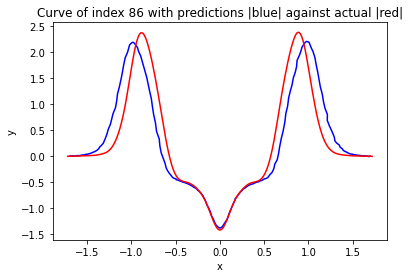

The loss of the curve 0.31793102503751863


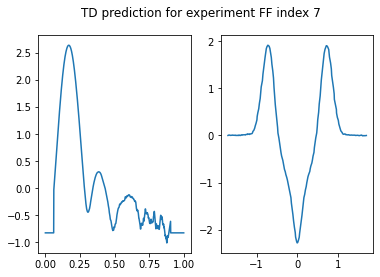

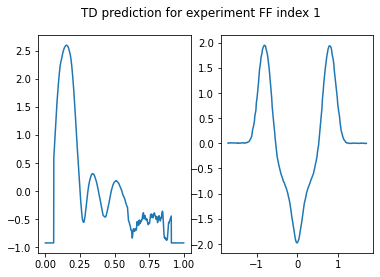

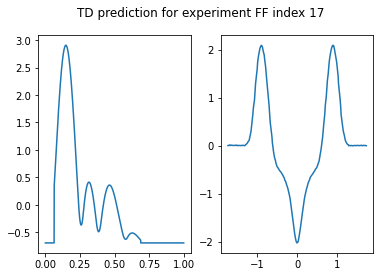

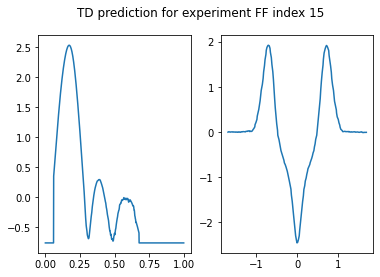

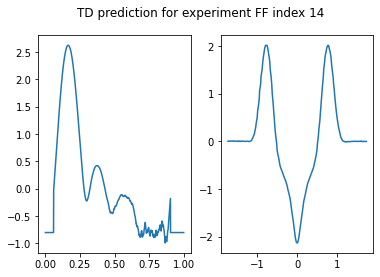

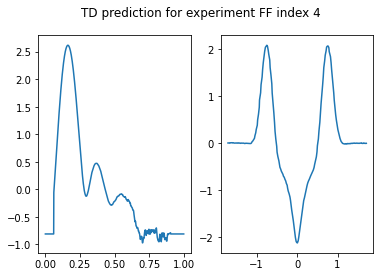

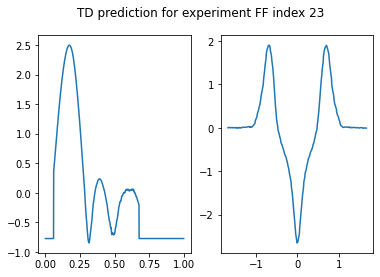

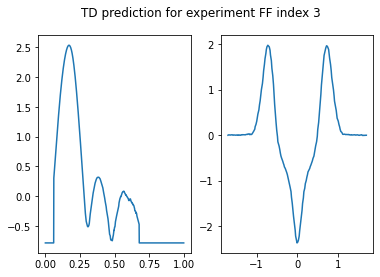

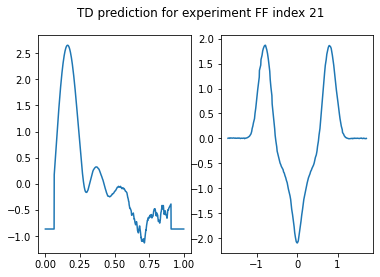

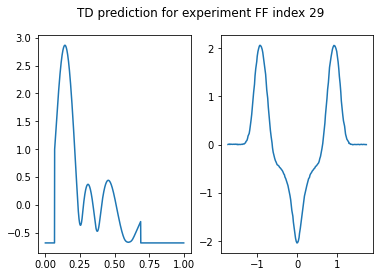

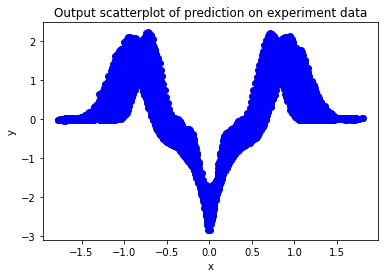

In [15]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=300, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(1500, activation='relu')(inputs)
x = layers.Dropout(0.1, seed = 42)(x)
x = layers.Dense(500, activation='relu')(x)
x = layers.Dropout(0.15, seed = 42)(x)
x = layers.Dense(500, activation='relu')(x)
x = layers.Dropout(0.05, seed = 42)(x)
x = layers.Dense(2500, activation='relu')(x)
x = layers.Dropout(0.05, seed = 42)(x)
x = layers.Dense(1500, activation='relu')(x)
x = layers.Dropout(0.1, seed = 42)(x)
outputs = layers.Dense(400, activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adamax(), loss='mean_absolute_error')

history = model.fit(train_input, train_output, batch_size=300, epochs=2000, validation_split=0.2, callbacks=callbacks, verbose=0)

general_end_time = time.time()

print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')

results = metrics(test_output, model.predict(test_input))

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
simulation_plots(test_output,model.predict(test_input))
experiment_predictions(exp_input,model.predict(exp_input))

Used time: 206.26596808433533 seconds


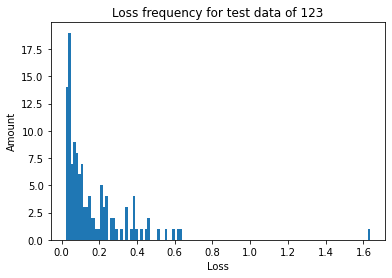

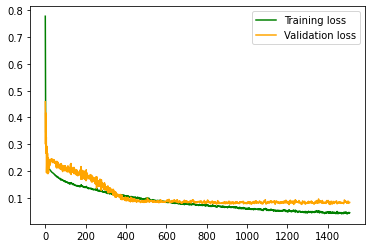

Loss average is: 0.16789381055606795
Loss mode is: [(0.027, 2), (0.11064, 1), (0.59236, 1), (0.09453, 1), (0.21376, 1), (0.379, 1), (0.04397, 1), (0.07671, 1), (1.63536, 1), (0.07528, 1)]
Loss median is: 0.09611


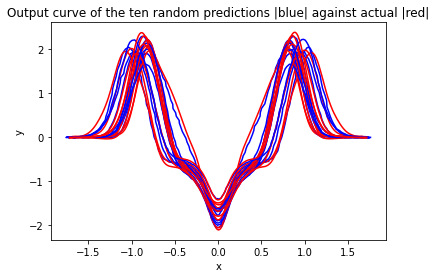

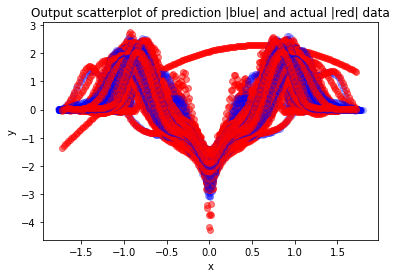

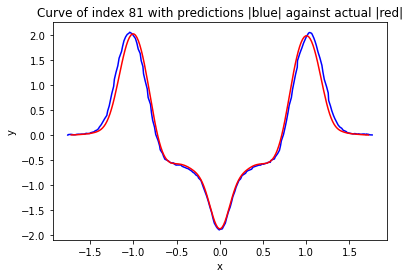

The loss of the curve 0.03830052070932338


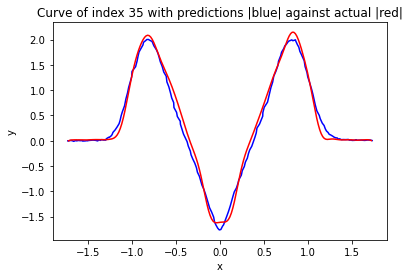

The loss of the curve 0.08795264119195484


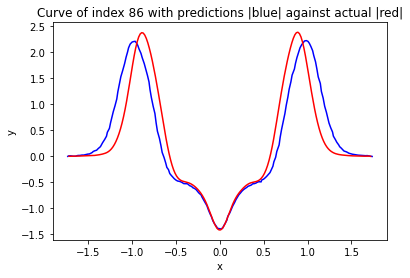

The loss of the curve 0.2712856945451817


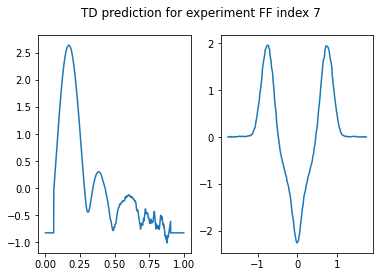

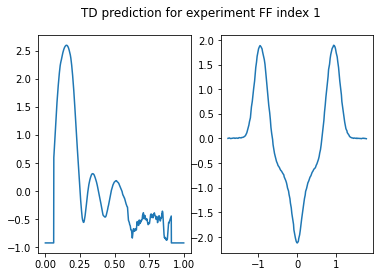

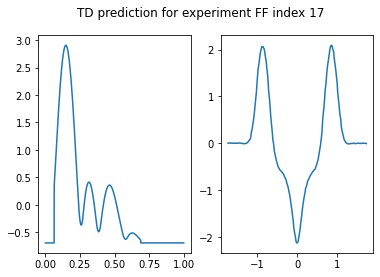

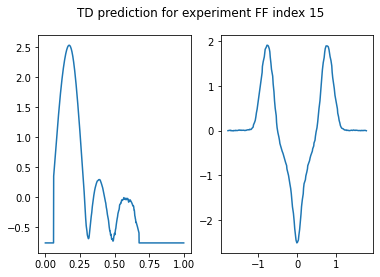

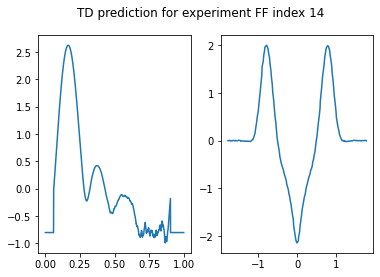

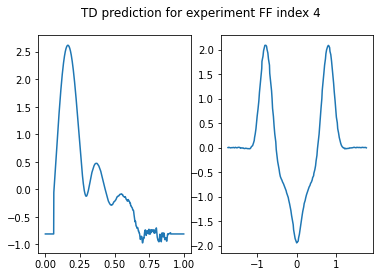

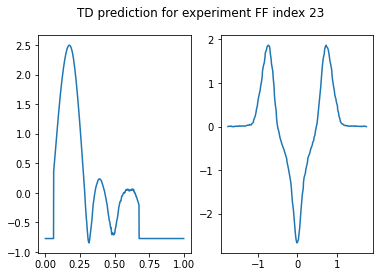

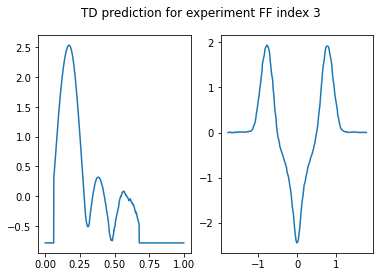

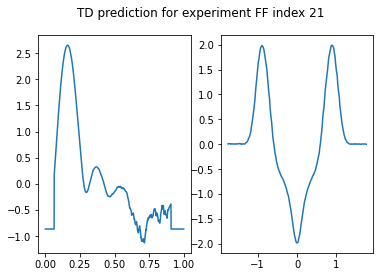

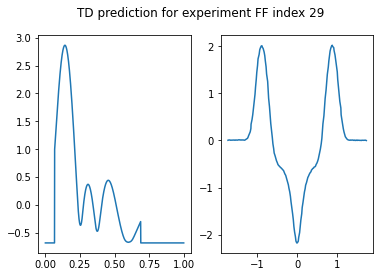

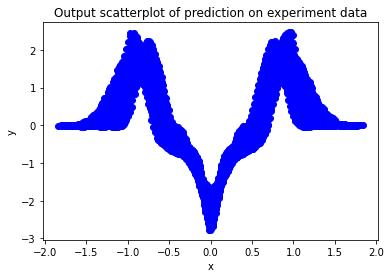

In [5]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=300, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(1500, activation='relu')(inputs)
x = layers.Dropout(0.1, seed = 42)(x)
x = layers.Dense(500, activation='relu')(x)
x = layers.Dropout(0.15, seed = 42)(x)
x = layers.Dense(500, activation='relu')(x)
x = layers.Dropout(0.05, seed = 42)(x)
x = layers.Dense(2500, activation='relu')(x)
x = layers.Dropout(0.05, seed = 42)(x)
x = layers.Dense(1500, activation='relu')(x)
x = layers.Dropout(0.1, seed = 42)(x)
outputs = layers.Dense(400, activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adamax(), loss='mean_absolute_error')

history = model.fit(train_input, train_output, batch_size=300, epochs=2000, validation_split=0.2, callbacks=callbacks, verbose=0)

general_end_time = time.time()

print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')

results = metrics(test_output, model.predict(test_input))

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
simulation_plots(test_output,model.predict(test_input))
experiment_predictions(exp_input,model.predict(exp_input))

Trial 254 Complete [00h 00m 56s]
val_loss: 0.10461819171905518

Best val_loss So Far: 0.09642695635557175
Total elapsed time: 00h 19m 05s
INFO:tensorflow:Oracle triggered exit
{'num_layers': 5, 'dense_0_units': 2500, 'dropout_0': 0.05, 'dense_1_units': 500, 'dropout_1': 0.2, 'dense_2_units': 1500, 'dropout_2': 0.25, 'dense_3_units': 500, 'dropout_3': 0.25, 'dense_4_units': 1500, 'dropout_4': 0.25, 'tuner/epochs': 100, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2500)              2502500   
_________________________________________________________________
dropout (Dropout)            (None, 2500)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               1250500   
________________________________

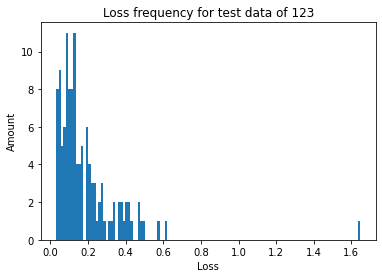

Loss average is: 0.18602077378303322
Loss mode is: [(0.19611, 1), (0.57954, 1), (0.36988, 1), (0.20955, 1), (0.47665, 1), (0.07012, 1), (0.06254, 1), (1.64825, 1), (0.174, 1), (0.07528, 1)]
Loss median is: 0.12855


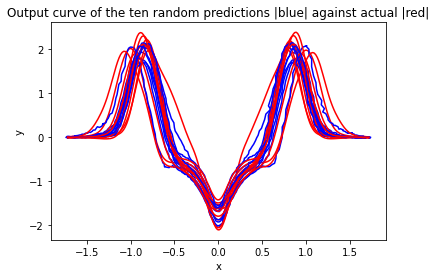

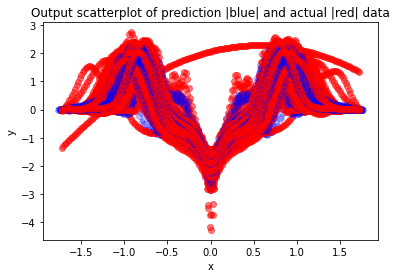

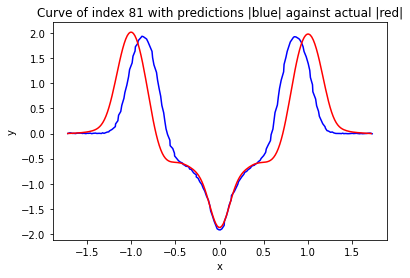

The loss of the curve 0.3708226333702639


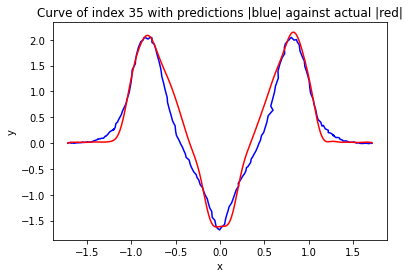

The loss of the curve 0.1585419393409776


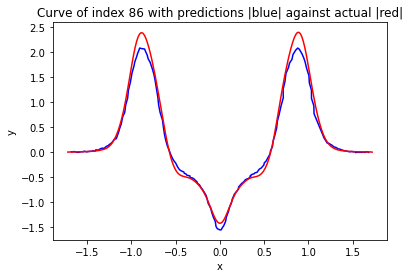

The loss of the curve 0.09385442159585355


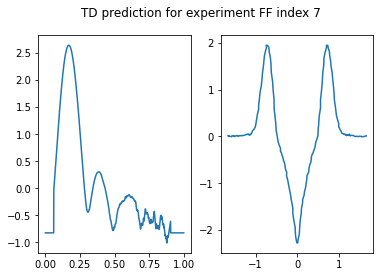

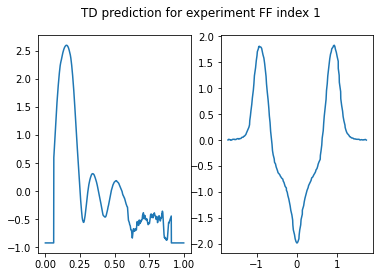

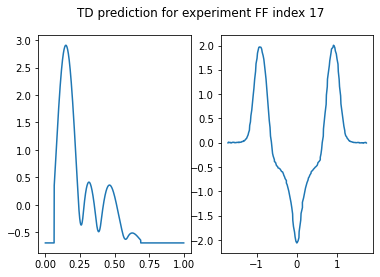

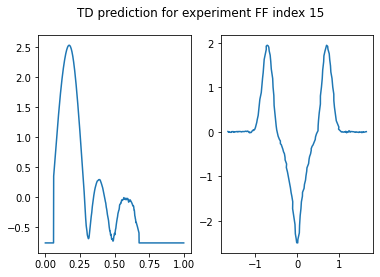

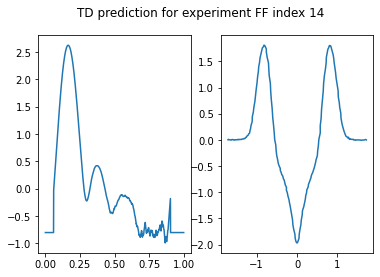

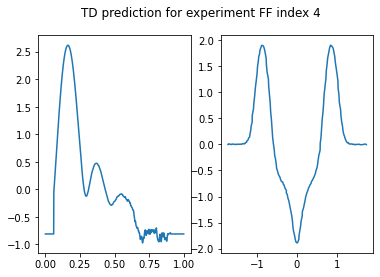

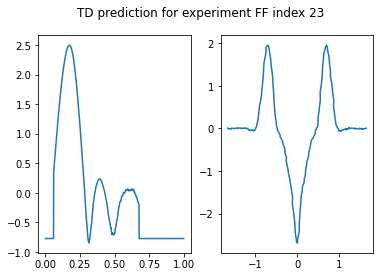

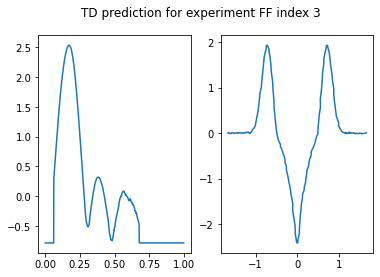

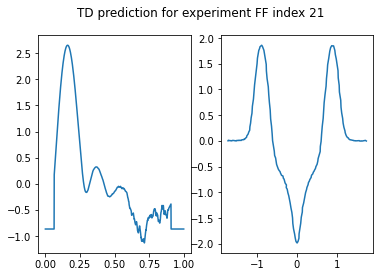

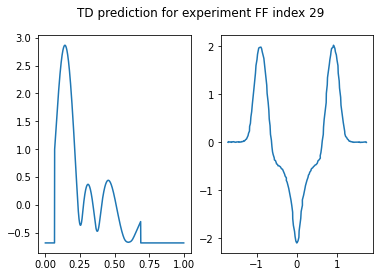

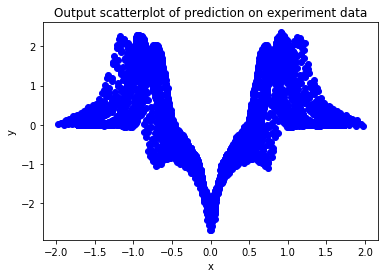

In [7]:
from keras.layers import LeakyReLU

def build_model(hp):
    model = keras.Sequential()
    
    model.add(layers.Input(shape=(1000,)))
    
    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(layers.Dense(units=hp.Int(f'dense_{i}_units', min_value=500, max_value=3000, step=500), activation = 'relu'))
        model.add(layers.Dropout(hp.Float(f'dropout_{i}', min_value=0.05, max_value=0.30, step=0.05), seed=42))
    
    model.add(layers.Dense(units=400, activation = 'linear'))
    
    model.compile(optimizer=tf.keras.optimizers.Adamax(),loss='mean_absolute_error')
    
    return model

tuner = Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=100,
    factor=3,
    directory='my_dir',
    project_name='FF_to_TD_15')

tuner.search(train_input, train_output,
             epochs=100,
             validation_data=(test_input, test_output))

best_model = tuner.get_best_models(num_models=1)[0]

best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)

two_best_models = tuner.get_best_models(num_models=1)
print(two_best_models[0].summary())

results = metrics(test_output, best_model.predict(test_input))
print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
simulation_plots(test_output,best_model.predict(test_input))
experiment_predictions(exp_input,best_model.predict(exp_input))

Used time: 141.6666431427002 seconds


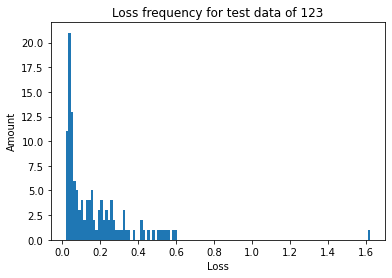

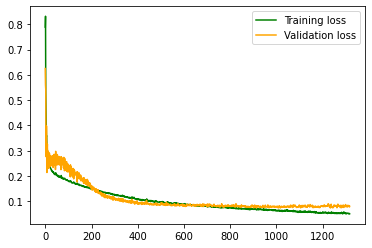

Loss average is: 0.17284942210846638
Loss mode is: [(0.15712, 1), (0.60282, 1), (0.1189, 1), (0.17377, 1), (0.50423, 1), (0.02792, 1), (0.22059, 1), (1.6227, 1), (0.15062, 1), (0.10989, 1)]
Loss median is: 0.11004


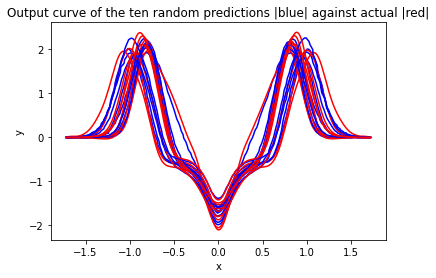

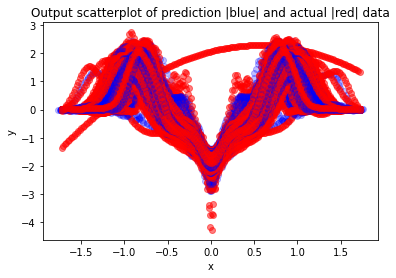

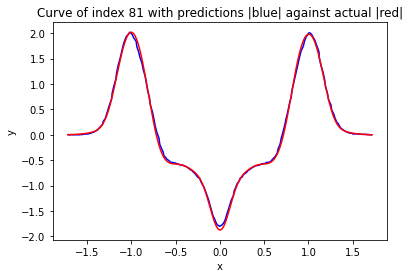

The loss of the curve 0.03806092145805382


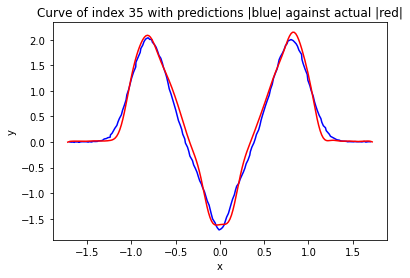

The loss of the curve 0.11143539420033752


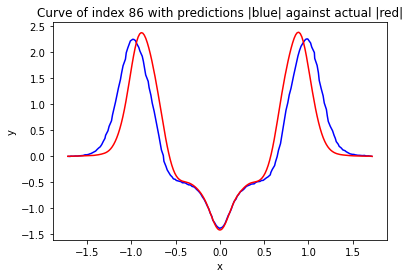

The loss of the curve 0.29969531822258877


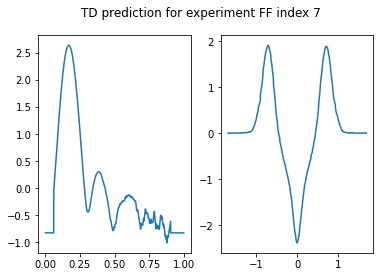

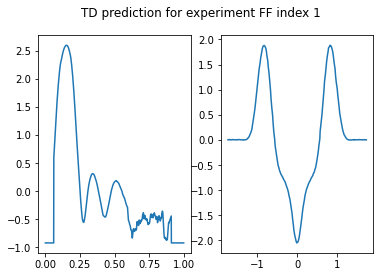

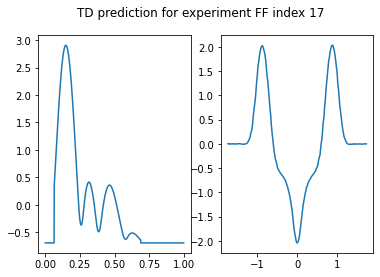

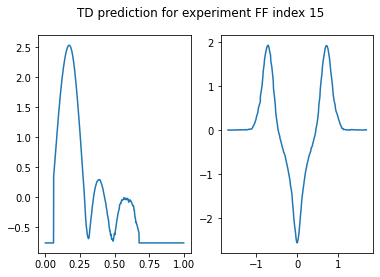

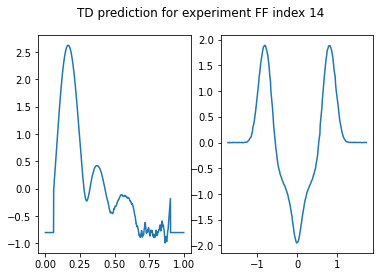

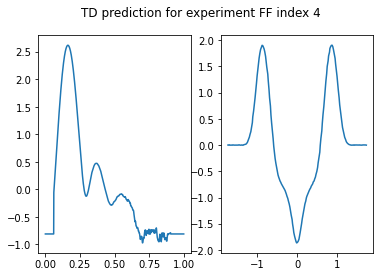

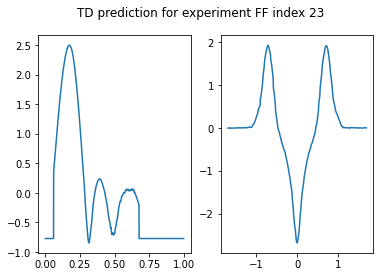

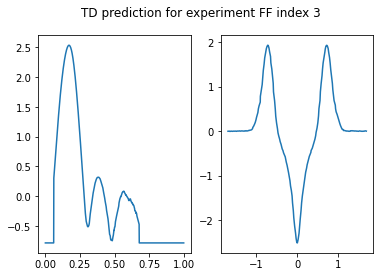

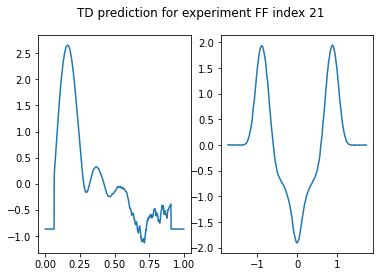

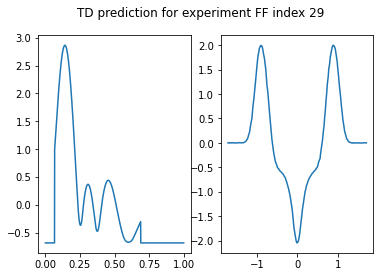

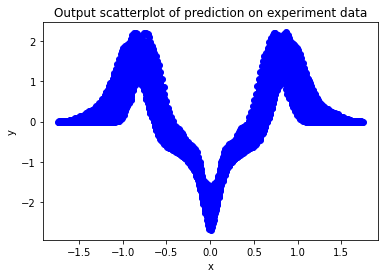

In [8]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=300, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(2500, activation='relu')(inputs)
x = layers.Dropout(0.05, seed = 42)(x)
x = layers.Dense(500, activation='relu')(x)
x = layers.Dropout(0.2, seed = 42)(x)
x = layers.Dense(1500, activation='relu')(x)
x = layers.Dropout(0.25, seed = 42)(x)
x = layers.Dense(500, activation='relu')(x)
x = layers.Dropout(0.25, seed = 42)(x)
x = layers.Dense(1500, activation='relu')(x)
x = layers.Dropout(0.25, seed = 42)(x)
outputs = layers.Dense(400, activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adamax(), loss='mean_absolute_error')

history = model.fit(train_input, train_output, batch_size=300, epochs=2000, validation_split=0.2, callbacks=callbacks, verbose=0)

general_end_time = time.time()

print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')

results = metrics(test_output, model.predict(test_input))

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Loss 50th quantile: ' + str(results[3]))
print('Loss 80th quantile: ' + str(results[4]))
print('Loss 95th quantile: ' + str(results[5]))
simulation_plots(test_output,model.predict(test_input))
experiment_predictions(exp_input,model.predict(exp_input))

Used time: 151.66705513000488 seconds


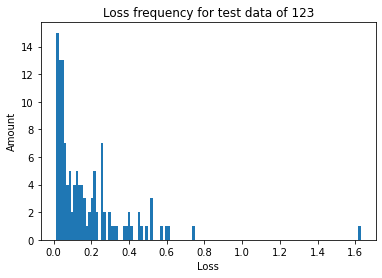

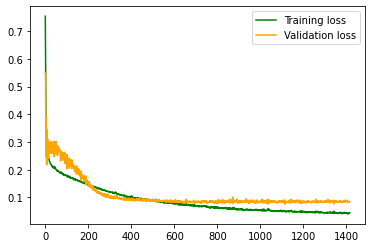

Loss average is: 0.17456867268980203
Loss mode is: [(0.13674, 1), (0.60865, 1), (0.11592, 1), (0.19442, 1), (0.5123, 1), (0.02152, 1), (0.45111, 1), (1.62826, 1), (0.2176, 1), (0.12423, 1)]
Loss median is: 0.1162
Loss 50th quantile: 0.11619614757989932
Loss 80th quantile: 0.256502941172837
Loss 95th quantile: 0.5132817204157955


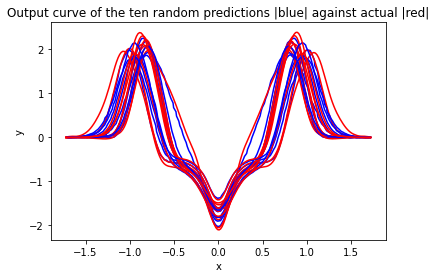

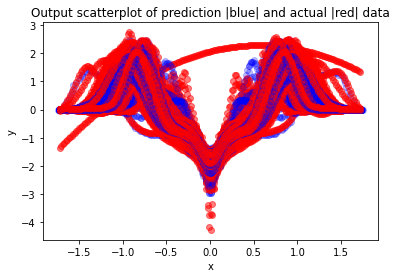

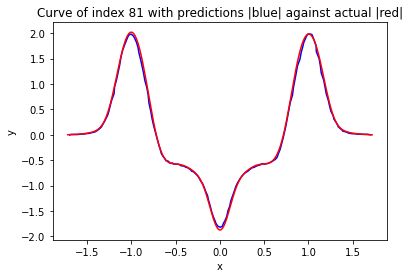

The loss of the curve 0.04596502076344973


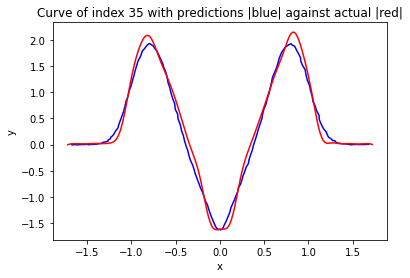

The loss of the curve 0.12234783131250855


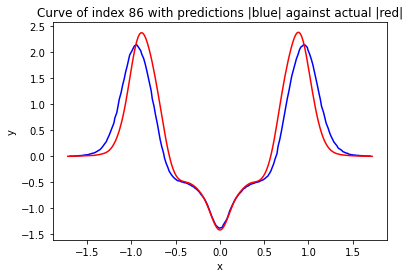

The loss of the curve 0.2496429934268454


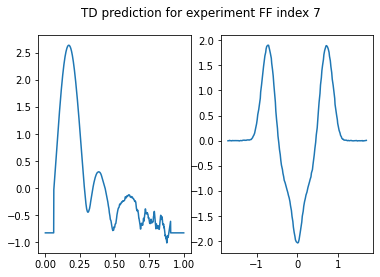

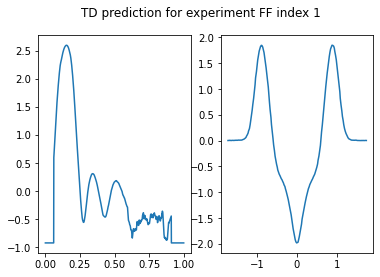

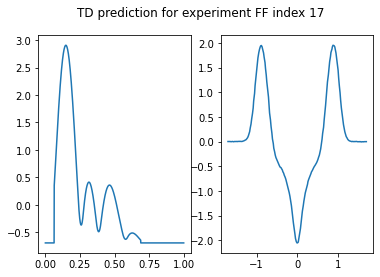

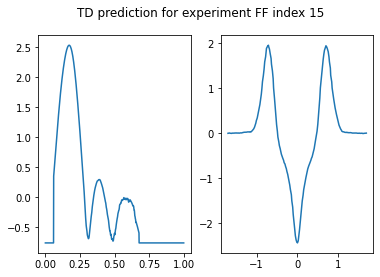

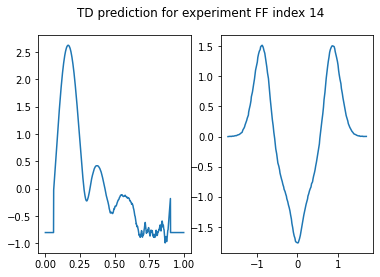

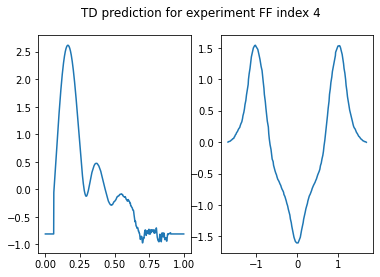

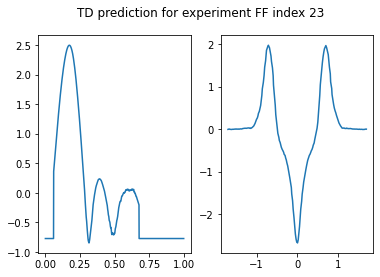

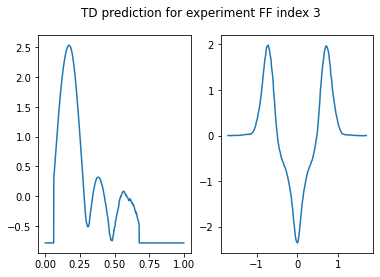

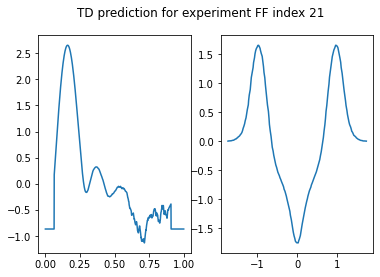

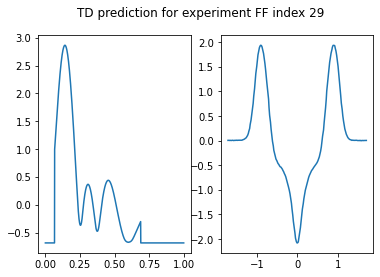

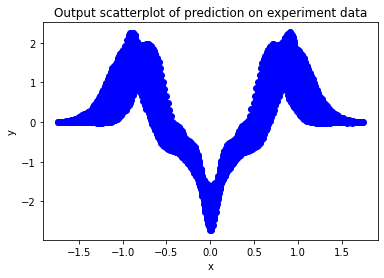

In [10]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=300, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(2500, activation='relu')(inputs)
x = layers.Dropout(0.05, seed = 42)(x)
x = layers.Dense(500, activation='relu')(x)
x = layers.Dropout(0.2, seed = 42)(x)
x = layers.Dense(1500, activation='relu')(x)
x = layers.Dropout(0.25, seed = 42)(x)
x = layers.Dense(500, activation='relu')(x)
x = layers.Dropout(0.25, seed = 42)(x)
x = layers.Dense(1500, activation='relu')(x)
x = layers.Dropout(0.25, seed = 42)(x)
outputs = layers.Dense(400, activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adamax(), loss='mean_absolute_error')

history = model.fit(train_input, train_output, batch_size=200, epochs=2000, validation_split=0.2, callbacks=callbacks, verbose=0)

general_end_time = time.time()

print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')

results = metrics(test_output, model.predict(test_input))

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Loss 50th quantile: ' + str(results[3]))
print('Loss 80th quantile: ' + str(results[4]))
print('Loss 95th quantile: ' + str(results[5]))
simulation_plots(test_output,model.predict(test_input))
experiment_predictions(exp_input,model.predict(exp_input))

Used time: 127.241539478302 seconds


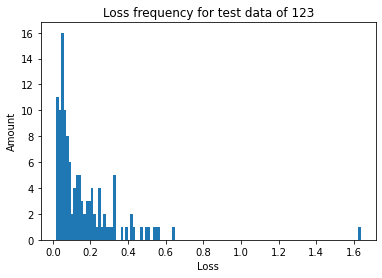

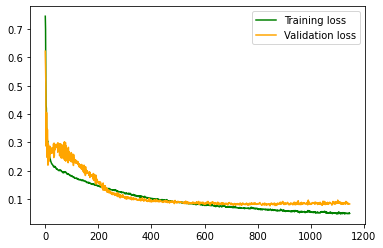

Loss average is: 0.16668343288782858
Loss mode is: [(0.13529, 1), (0.413, 1), (0.13727, 1), (0.20219, 1), (0.46774, 1), (0.09059, 1), (0.39113, 1), (1.63504, 1), (0.14832, 1), (0.08262, 1)]
Loss median is: 0.09789
Loss 50th quantile: 0.09789383305788402
Loss 80th quantile: 0.24952357453729396
Loss 95th quantile: 0.4905994805858649


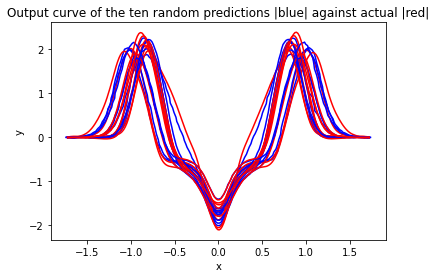

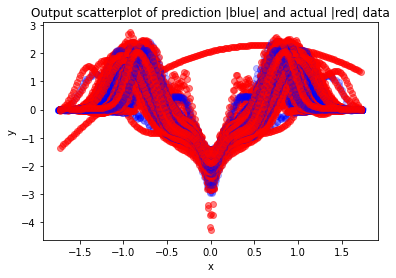

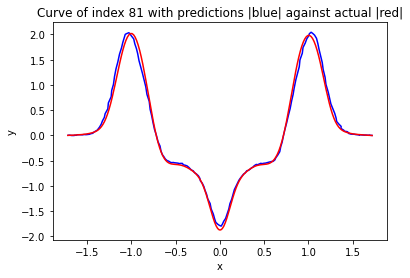

The loss of the curve 0.0548154877297279


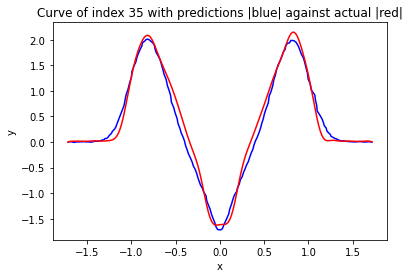

The loss of the curve 0.11992845359892383


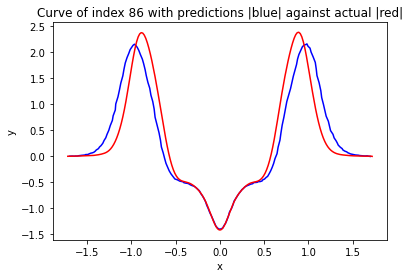

The loss of the curve 0.28786573831944823


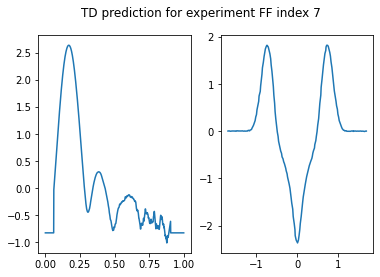

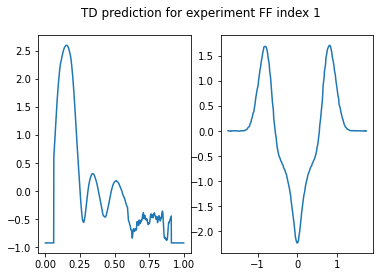

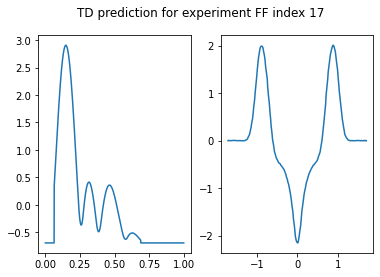

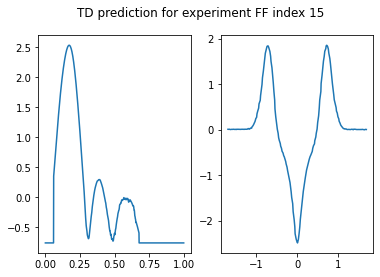

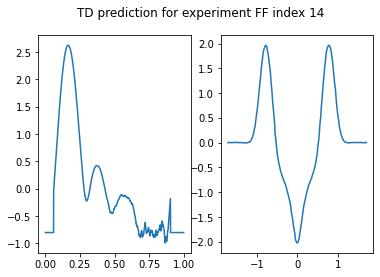

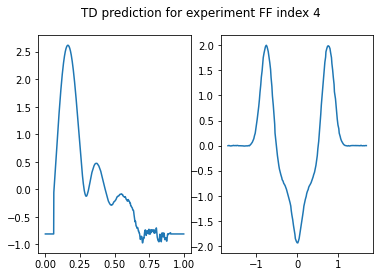

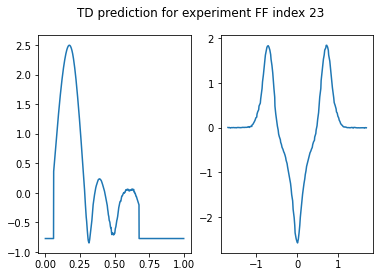

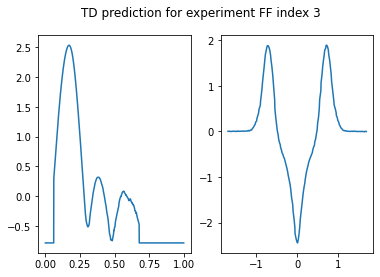

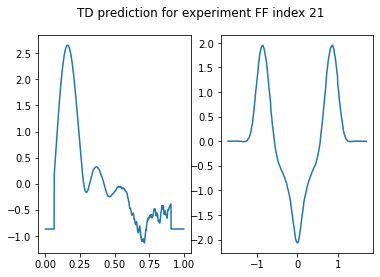

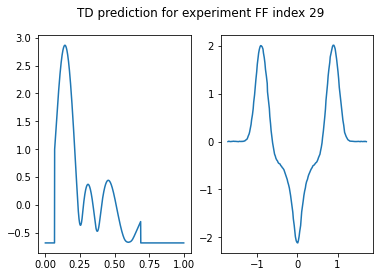

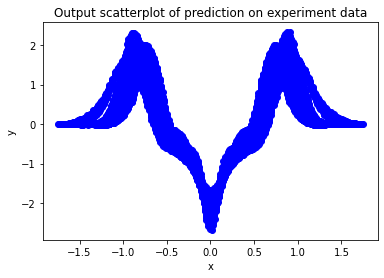

In [6]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=300, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(2500, activation='relu')(inputs)
x = layers.Dropout(0.05, seed = 42)(x)
x = layers.Dense(500, activation='relu')(x)
x = layers.Dropout(0.2, seed = 42)(x)
x = layers.Dense(1500, activation='relu')(x)
x = layers.Dropout(0.25, seed = 42)(x)
x = layers.Dense(500, activation='relu')(x)
x = layers.Dropout(0.25, seed = 42)(x)
x = layers.Dense(1500, activation='relu')(x)
x = layers.Dropout(0.25, seed = 42)(x)
outputs = layers.Dense(400, activation='linear')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adamax(), loss='mean_absolute_error')

history = model.fit(train_input, train_output, batch_size=200, epochs=2000, validation_split=0.2, callbacks=callbacks, verbose=0)

general_end_time = time.time()

print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')

results = metrics(test_output, model.predict(test_input))

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Loss 50th quantile: ' + str(results[3]))
print('Loss 80th quantile: ' + str(results[4]))
print('Loss 95th quantile: ' + str(results[5]))
simulation_plots(test_output,model.predict(test_input))
experiment_predictions(exp_input,model.predict(exp_input))

In [7]:
model.save('Experimental_FF_to_TD_MVP.h5')